# **Computing almost-commuting basis of Ordinary Differential Operators**

In [1]:
import sys
sys.path.insert(0,"..") # dalgebra is here

from dalgebra import *
%display latex
from dalgebra.hierarchies import *

In this notebook we show how to use `dalgebra` for computing a basis of quasi-commuting operators (or at least the conditions to have one). This is based on results from 
* [6] G. Wilson, _Algebraic curves and solution equations_, Geometry Today, 1985, pp. 303-329,

and also in some current and recent research from:
* [3] J.J. Morales-Ruiz, S.L. Rueda and M.A. Zurro, _Factorization of KdV Schrödinger operators using differential subresultants_, Adv. Applied Mathematics **120** (2020), 102065
* [4] E. Previato, S.L. Rueda and M.A. Zurro, _Commuting Ordinary Differential Operators and the Dixmier Test_, "SIGMA (Symmetry, integrability and Geometry: Methods and Application)" **15** (2019) no. 101, 23 pp.

## **1. The problem**

Let us consider a linear differential operator of the form:
$$L = \partial^n  + u_{n-2}\partial^{n-2} + \ldots + u_1\partial + u_0,$$
where the variables $u_*$ are in some differential field $K$ with constant field within $\mathbb{C}$. The centralizers of these operators have quotient fields that can be seen as affine rings over curves. This can be used to described and understand better the centralizers of $L$ and some of its properties.

**Definition** _(almost commuting)_: let $A,B \in K[\partial]$ be of order $n$ and $m$ respectively. We say that $B$ almost commute with $A$ if $\text{ord}([A,B]) \leq n-2$.

By definition, two operators commute when $[A,B] = 0$ and, in general, this commutator have order $n+m-1$. Hence, if the order of the commutator is _so small_ that is smaller than $n-1$, then we consider the operator $B$ _almost commute_ with $A$. 

**_Remark_**: _almost commuting_ is not a symmetric property: if $\text{ord}([A,B]) = n-2$ and $n > m$ then $B$ almost commutes with $A$ but $A$ does not almost commute with $B$.

### Almost commuting operators: their structure

**Lemma** let $A \in K[\partial]$. Then the set of $B$ such that $B$ almost commute with $A$ is a $\mathbb{C}$-vector space.

_Proof:_ this is trivial using the properties of $[\cdot,\cdot]$:
* $[A, B+C] = AB + AC - BA - CA = [A,B] + [A,C]$. Hence $\text{ord}([A,B+C]) \leq \max\{\text{ord}([A,B]), \text{ord}([A,C])\} \leq n-2$.
* If $\partial(c) = 0$, then $[A,cB] = c[A,B]$. Hence, $\text{ord}([A,cB]) = \text{ord}([A,B]) \leq n-2$.

As it usually happens with this type of vector spaces of operators, we can consider them sliced into the orders of the operators. In particular, we have that the sets
$$AC_m(A) = \left\{B \in K[\partial]\ :\ \text{$B$ almost commute with $A$ and $\text{ord}(B) \leq m$}\right\}$$
are subspaces of the space of almost commuting operators.

It was shown in [6] that the vector spaces $AC_m(A)$ has exactly dimension $m$. This, together with the fact that $AC_m(A) \subset AC_{m+1}(A)$, means that there is an operator of order exactly $m$ that almost commute with $A$. This operator can be uniquely defined if provided more properties.

**_Remark_**: if $B$ commutes with $A$, then $B$ almost commute with $A$.

**Theorem [6]** Let $L = \partial^n  + u_{n-2}\partial^{n-2} + \ldots + u_1\partial + u_0$ and assign weights $u_{j}^{(k)} = n-j+k$. Then there is a unique basis $\{P_m\ :\ m \in \mathbb{N}\}\subset K\{u_0,\ldots,u_{n-2}\}[\partial]$ such that
* $P_m = \partial_m + p_{m,m-2}\partial^{m-2} + ... + p_{m,1}\partial + p_{m,0}$.
* The coefficients $p_{m,j}$ are homogeneous of weight $m-j$.

## **2. Using `dalgebra` to set up the system for quasi-commutation**

First, we start by defining the basic system that need to be satisfied. We start by creating the d-variables for $L$ and $P_m$:

In [39]:
from itertools import accumulate
n=3; m=5
names_u = ["u"] if n == 2 else [f"u{i}" for i in range(n-1)]
names_p = ["p"] if m == 2 else [f"p{i+2}" for i in range(m-1)]
R = DifferentialPolynomialRing(QQ, names_p + names_u + ["z"]); R
p, u, z = R.gens()[:m-1], R.gens()[m-1:m+n-2], R.gens()[-1]
L = z[n] + sum(z[i]*u[i][0] for i in range(n-1))
P = z[m] + sum(z[m-i]*p[i-2][0] for i in range(2,m+1))

We then proceed to compute the commutator between $L$ and $P$:

In [41]:
C = L(z=P) - P(z=L)
system = DifferentialSystem([C.coefficient(z[i]) for i in range(n-1, C.order(z)+1)], variables=p)
system

System over [Ring of operator polynomials in (p2, p3, p4, p5, u0, u1, z) over Differential Ring [[Rational Field], (0,)]] with variables [(p2_*, p3_*, p4_*, p5_*)]:
{
	(-3)*p2_0*u0_1 + (-3)*p2_0*u1_2 + p3_1*u1_0 + (-2)*p3_0*u1_1 + p3_3 + 3*p4_2 + 3*p5_1 + (-10)*u0_3 + (-5)*u1_4 == 0
	p2_1*u1_0 + (-3)*p2_0*u1_1 + p2_3 + 3*p3_2 + 3*p4_1 + (-10)*u0_2 + (-10)*u1_3 == 0
	3*p2_2 + 3*p3_1 + (-5)*u0_1 + (-10)*u1_2 == 0
	3*p2_1 + (-5)*u1_1 == 0
}

## **3. Solving the differential system**

At this point, we need to solve the differential system depicted above, i.e., find expressions for the variables $Yj_*$ in terms of the $ui_*$ that satisfy all the previous equations.

### 3.1 A differential solver

We can rely on the method `solve_linear` of the class `DSystem` to try and solve the system by integrating. This usually implies the computation of some integration constants and maybe the output we obtain is not homogeneous in term of the Wilson's weights. We need to check that before returning:

In [42]:
sols = system.solve_linear(); sols

{p2_*: 5/3*u1_0,
 p3_*: 5/3*u0_0 + 5/3*u1_1,
 p4_*: 5/9*u1_0^2 + 5/3*u0_1 + 10/9*u1_2,
 p5_*: 10/9*u0_0*u1_0 + 10/9*u0_2}

In [43]:
## Checking the Wilson condition over the obtained values
weight = R.weight_func({u[i]: n-i for i in range(n-1)}, [1])
for i in range(m-2):
    if not weight.is_homogeneous(sols[p[i]]):
        raise ValueError(f"The generator {p[i]} is not homogeneous")
    if weight(sols[p[i]]) != i+2:
        raise ValueError(f"The weight of {p[i]} is not {m-i}, but {weight(sols[p[i]])}")
print("All the variables are homogeneous of appropriate weight")

All the variables are homogeneous of appropriate weight


### 3.2 An ansatz approach

Solving a differential system may be tricky and difficult to implement. Even more when the coefficients stop being generic and we need an effective integration method for solving such system. This is why we propose an ansatz approach that will exploit the Wilson's weight condition:

**Remark** Let $R = K\{u_0,\ldots,u_{n-2}\}$ with a weight function defined by $w(u_i^{k}) = n-i+k$. Let $\mathcal{T}$ be the multiplicative monoid of monomials of $R$. Then:
* $\mathcal{T} = \bigsqcup_{d \in \mathbb{N}}T_d$ where $T_d = \{t \in \mathcal{T}\ :\ w(t) = d\}$,
* $|T_d| < \infty$.

In fact, we can give a recursive formulation that will allow us to compute (with some repetition) these monomials.

**Lemma** Let $t\in \mathcal{T}$. Then $w(\partial(t)) = w(t)+1$.

**Lemma** Let $d \in \mathbb{N}$ with $d \geq n$. Then
$$T_d = \left(\bigcup_{i=0}^{n-2} u_{i} T_{d-n+i}\right) \cup \partial(T_{d-1}).$$
Hence, we can bound the number of homogeneous monomials of weight $d$ with a $n$-bonacci sequence (see [this](https://oeis.org/wiki/N-bonacci_numbers)).

This is the lemma used in the method `homogeneous_monomials` in the `WeightFunction` class to compute the homogeneous monomials of a given weight:

In [45]:
weight = R.weight_func((m-1)*[0]+list(range(n,1,-1))+[0],[1])
ansatz_monoms = [weight.homogeneous_monomials(i) for i in range(m+1)]
for i in range(m+1):
    print(f"{i} -> {len(ansatz_monoms[i])} | {ansatz_monoms[i]}")
    
lengths = [len(mons) for mons in ansatz_monoms]
num_constants = sum(len(mons) for mons in ansatz_monoms)

0 -> 1 | {1}
1 -> 0 | set()
2 -> 1 | {u1_0}
3 -> 2 | {u0_0, u1_1}
4 -> 3 | {u1_0^2, u1_2, u0_1}
5 -> 4 | {u0_2, u0_0*u1_0, u1_3, u1_1*u1_0}


Then, we can set up ansatzs for all the variables $Y_j$ where we set:
$$Y_j = \sum_{t\in T_{m-j}}c_{j,t}t,$$
where now the values $c_{j,t} \in \mathbb{C}$ are simply constants.

In [48]:
BwC = PolynomialRing(QQ, [f"c_{j}_{i}" for (j,mons) in enumerate(ansatz_monoms) for i in range(len(mons))])
cs = BwC.gens()
c = [cs[x - y: x] for x, y in zip(accumulate(lengths), lengths)]
RwC = R.change_ring(DifferentialRing(BwC, lambda p : 0))
p, u, z = RwC.gens()[:m-1], RwC.gens()[m-1:m+n-2], RwC.gens()[-1]
## Creating the ansatzs
pc = {p[i] : sum(coeff*RwC(monom) for (coeff,monom) in zip(c[i+2], ansatz_monoms[i+2])) for i in range(m-1)}; pc

{p2_*: c_2_0*u1_0,
 p3_*: c_3_0*u0_0 + c_3_1*u1_1,
 p4_*: c_4_0*u1_0^2 + c_4_2*u0_1 + c_4_1*u1_2,
 p5_*: c_5_1*u0_0*u1_0 + c_5_3*u1_1*u1_0 + c_5_0*u0_2 + c_5_2*u1_3}

The next step is to plug these ansatz into the equations from the system:

In [50]:
## Building the linear system
CwC = RwC(C)
equations = [RwC(equ)(dic=pc) for equ in system.equations()]
for equ in equations: show(latex(equ) + r" = 0")

\left(-3 c_{2_{0}} + c_{3_{0}} + 3 c_{5_{1}}\right) \mathit{u0}_{1} \mathit{u1}_{0} + \left(-2 c_{3_{0}} + 3 c_{5_{1}}\right) \mathit{u0}_{0} \mathit{u1}_{1} + \left(-3 c_{2_{0}} + c_{3_{1}} + 6 c_{4_{0}} + 3 c_{5_{3}}\right) \mathit{u1}_{2} \mathit{u1}_{0} + \left(-2 c_{3_{1}} + 6 c_{4_{0}} + 3 c_{5_{3}}\right) \mathit{u1}_{1}^{2} + \left(c_{3_{0}} + 3 c_{4_{2}} + 3 c_{5_{0}} - 10\right) \mathit{u0}_{3} + \left(c_{3_{1}} + 3 c_{4_{1}} + 3 c_{5_{2}} - 5\right) \mathit{u1}_{4} = 0

\left(-2 c_{2_{0}} + 6 c_{4_{0}}\right) \mathit{u1}_{1} \mathit{u1}_{0} + \left(3 c_{3_{0}} + 3 c_{4_{2}} - 10\right) \mathit{u0}_{2} + \left(c_{2_{0}} + 3 c_{3_{1}} + 3 c_{4_{1}} - 10\right) \mathit{u1}_{3} = 0

\left(3 c_{3_{0}} - 5\right) \mathit{u0}_{1} + \left(3 c_{2_{0}} + 3 c_{3_{1}} - 10\right) \mathit{u1}_{2} = 0

\left(3 c_{2_{0}} - 5\right) \mathit{u1}_{1} = 0

In order to obtain a solution to this system, we just need to make all the constant coefficients be zero. This lead to a set of equations in the ansatz variables. Due to the original structure of the differential system, this new system in the ansatz variables is linear:

In [51]:
equations = sum([equ.coefficients() for equ in equations], [])
A = Matrix([[equ.wrapped.coefficient(v) for v in cs] for equ in equations]); b = vector([equ.wrapped.constant_coefficient() for equ in equations])
show(latex(A) + r"\begin{pmatrix}" + r"\\".join([latex(v) for v in cs]) + r"\end{pmatrix} = " + latex(b.column()))

\left(\begin{array}{rrrrrrrrrrr}
0 & -3 & 1 & 0 & 0 & 0 & 0 & 0 & 3 & 0 & 0 \\
0 & 0 & -2 & 0 & 0 & 0 & 0 & 0 & 3 & 0 & 0 \\
0 & -3 & 0 & 1 & 6 & 0 & 0 & 0 & 0 & 0 & 3 \\
0 & 0 & 0 & -2 & 6 & 0 & 0 & 0 & 0 & 0 & 3 \\
0 & 0 & 1 & 0 & 0 & 0 & 3 & 3 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 3 & 0 & 0 & 0 & 3 & 0 \\
0 & -2 & 0 & 0 & 6 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 3 & 0 & 0 & 0 & 3 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 3 & 0 & 3 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 3 & 0 & 3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{array}\right) \begin{pmatrix} c_{0_{0}}\\c_{2_{0}}\\c_{3_{0}}\\c_{3_{1}}\\c_{4_{0}}\\c_{4_{1}}\\c_{4_{2}}\\c_{5_{0}}\\c_{5_{1}}\\c_{5_{2}}\\c_{5_{3}} \end{pmatrix} = \left(\begin{array}{r}
0 \\
0 \\
0 \\
0 \\
-10 \\
-5 \\
0 \\
-10 \\
-10 \\
-5 \\
-10 \\
-5
\end{array}\right)

At this stage, we only need to find a solution to this linear system. Since the Wilson basis was unique, then the solution of this system must also be unique. 

In [54]:
sols = A.solve_right(-b)
## Building output ring
output_ring = DifferentialPolynomialRing(QQ, names_u + ["z"])
output_z = output_ring.gens()[-1]

## Computing the output operator
p, u, z = R.gens()[:m-1], R.gens()[m-1:m+n-2], R.gens()[-1]
sols = [[output_ring.base()(el) for el in sols[x - y: x]] for x, y in zip(accumulate(lengths), lengths)]
sols = {p[i]: sum(coeff*output_ring(monom) for (coeff,monom) in zip(sols[i+2], ansatz_monoms[i+2])) for i in range(m-1)}
sols

{p2_*: 5/3*u1_0,
 p3_*: 5/3*u0_0 + 5/3*u1_1,
 p4_*: 5/9*u1_0^2 + 5/3*u0_1 + 10/9*u1_2,
 p5_*: 10/9*u0_0*u1_0 + 10/9*u0_2}

### 3.3 Returning the data

No matter how we solve the differential system (either by integrating or solving a linear ansatz problem), we then substitute in the original values the obtained coefficients to obtain the element in the Wilson basis of quasi-commutation and we can also plug in these values into the commutator to see what conditions remain for the $u_i$ functions to have an actual commutator:

In [55]:
P_with_sol = P(dic=sols)
C_with_sol = C(dic=sols)
T = tuple([C_with_sol.coefficient(z[i]) for i in range(n-1)])
(P,T)

(p2_0*z_3 + p3_0*z_2 + p4_0*z_1 + p5_0*z_0 + z_5,
 (5/9*u0_1*u1_0^2 + 10/9*u0_0*u1_1*u1_0 + 5/9*u0_3*u1_0 + (-5/3)*u0_2*u0_0 + 5/3*u0_2*u1_1 + (-5/3)*u0_1^2 + 20/9*u0_1*u1_2 + 10/9*u0_0*u1_3 + 1/9*u0_5,
  5/9*u1_1*u1_0^2 + (-10/3)*u0_1*u0_0 + 5/3*u0_1*u1_1 + 5/3*u0_0*u1_2 + 5/9*u1_3*u1_0 + 5/9*u1_2*u1_1 + 1/9*u1_5))

### 3.4 Implementation in `dalgebra`

Both procedures are implemented in `dalgebra` in the module `hierarchies.hierarchies`. The method `almost_commuting_wilson` is a method that given the values of `n`and `m` computes the `m`-th order element of the Wilson basis for the operator $L$ with order $n$. It also allows the user to specify which approach want to be used with the argument `method`. This method allow the input `"diff"` or `"linear"` for the integration or ansatz approach respectively.

## **4. Applications**

We now proceed to use this method to obtain the Wilson basis for several orders up to order 10. For standardize the output format, we provide this new function that will do all the job:

In [2]:
from dalgebra.hierarchies.hierarchies import almost_commuting_wilson
def get_sequence(n, bound, method="diff"):
    sequence = []
    for i in range(n, bound+1):
        P, T = almost_commuting_wilson(n,i,method=method)
        
        print("-------------------------------------------------------------------------------------------------------------------")
        print(f"Computed the almost commutator of order {i}")
        show(f"P_{i} = " + latex(P))

        if all(t == 0 for t in T):
            print("... This commutes with L")
            sequence.append((P, tuple([])))
        else:
            ltx_code = r"\left\{\begin{array}{rcl}"
            ltx_code += r"\\".join(r"f_{" + f"{i//n},{j}" + r"} & = & " + latex(T[j]) for j in range(len(T)))
            ltx_code += r"\end{array}\right."
            sequence.append((P, tuple([t for t in T if t != 0])))
            show(LatexExpr(ltx_code))
    return sequence

#### 4.1 Recovering the kdv sequence ($\text{ord}(L) = 2$)

In [3]:
%time seq=get_sequence(2, 10)

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 2


P_2 = 1 u_{0} z_{0} + 1 z_{2}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 3


P_3 = \frac{3}{4} u_{1} z_{0} + \frac{3}{2} u_{0} z_{1} + 1 z_{3}

\left\{\begin{array}{rcl}f_{1,0} & = & \left(-\frac{3}{2}\right) u_{1} u_{0} + \left(-\frac{1}{4}\right) u_{3}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 4


P_4 = 1 u_{0}^{2} z_{0} + 1 u_{2} z_{0} + 2 u_{1} z_{1} + 2 u_{0} z_{2} + 1 z_{4}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 5


P_5 = \frac{15}{8} u_{1} u_{0} z_{0} + \frac{15}{8} u_{0}^{2} z_{1} + \frac{15}{16} u_{3} z_{0} + \frac{25}{8} u_{2} z_{1} + \frac{15}{4} u_{1} z_{2} + \frac{5}{2} u_{0} z_{3} + 1 z_{5}

\left\{\begin{array}{rcl}f_{2,0} & = & \left(-\frac{15}{8}\right) u_{1} u_{0}^{2} + \left(-\frac{5}{8}\right) u_{3} u_{0} + \left(-\frac{5}{4}\right) u_{2} u_{1} + \left(-\frac{1}{16}\right) u_{5}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 6


P_6 = 1 u_{0}^{3} z_{0} + 3 u_{2} u_{0} z_{0} + 2 u_{1}^{2} z_{0} + 6 u_{1} u_{0} z_{1} + 3 u_{0}^{2} z_{2} + 1 u_{4} z_{0} + 4 u_{3} z_{1} + 7 u_{2} z_{2} + 6 u_{1} z_{3} + 3 u_{0} z_{4} + 1 z_{6}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 7


P_7 = \frac{105}{32} u_{1} u_{0}^{2} z_{0} + \frac{35}{16} u_{0}^{3} z_{1} + \frac{105}{32} u_{3} u_{0} z_{0} + \frac{105}{16} u_{2} u_{1} z_{0} + \frac{175}{16} u_{2} u_{0} z_{1} + \frac{245}{32} u_{1}^{2} z_{1} + \frac{105}{8} u_{1} u_{0} z_{2} + \frac{35}{8} u_{0}^{2} z_{3} + \frac{63}{64} u_{5} z_{0} + \frac{161}{32} u_{4} z_{1} + \frac{175}{16} u_{3} z_{2} + \frac{105}{8} u_{2} z_{3} + \frac{35}{4} u_{1} z_{4} + \frac{7}{2} u_{0} z_{5} + 1 z_{7}

\left\{\begin{array}{rcl}f_{3,0} & = & \left(-\frac{35}{16}\right) u_{1} u_{0}^{3} + \left(-\frac{35}{32}\right) u_{3} u_{0}^{2} + \left(-\frac{35}{8}\right) u_{2} u_{1} u_{0} + \left(-\frac{35}{32}\right) u_{1}^{3} + \left(-\frac{7}{32}\right) u_{5} u_{0} + \left(-\frac{21}{32}\right) u_{4} u_{1} + \left(-\frac{35}{32}\right) u_{3} u_{2} + \left(-\frac{1}{64}\right) u_{7}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 8


P_8 = 1 u_{0}^{4} z_{0} + 6 u_{2} u_{0}^{2} z_{0} + 8 u_{1}^{2} u_{0} z_{0} + 12 u_{1} u_{0}^{2} z_{1} + 4 u_{0}^{3} z_{2} + 4 u_{4} u_{0} z_{0} + 10 u_{3} u_{1} z_{0} + 16 u_{3} u_{0} z_{1} + 7 u_{2}^{2} z_{0} + 32 u_{2} u_{1} z_{1} + 28 u_{2} u_{0} z_{2} + 20 u_{1}^{2} z_{2} + 24 u_{1} u_{0} z_{3} + 6 u_{0}^{2} z_{4} + 1 u_{6} z_{0} + 6 u_{5} z_{1} + 16 u_{4} z_{2} + 24 u_{3} z_{3} + 22 u_{2} z_{4} + 12 u_{1} z_{5} + 4 u_{0} z_{6} + 1 z_{8}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 9


P_9 = \frac{315}{64} u_{1} u_{0}^{3} z_{0} + \frac{315}{128} u_{0}^{4} z_{1} + \frac{945}{128} u_{3} u_{0}^{2} z_{0} + \frac{945}{32} u_{2} u_{1} u_{0} z_{0} + \frac{1575}{64} u_{2} u_{0}^{2} z_{1} + \frac{945}{128} u_{1}^{3} z_{0} + \frac{2205}{64} u_{1}^{2} u_{0} z_{1} + \frac{945}{32} u_{1} u_{0}^{2} z_{2} + \frac{105}{16} u_{0}^{3} z_{3} + \frac{567}{128} u_{5} u_{0} z_{0} + \frac{1743}{128} u_{4} u_{1} z_{0} + \frac{1449}{64} u_{4} u_{0} z_{1} + \frac{3045}{128} u_{3} u_{2} z_{0} + \frac{1827}{32} u_{3} u_{1} z_{1} + \frac{1575}{32} u_{3} u_{0} z_{2} + \frac{5061}{128} u_{2}^{2} z_{1} + \frac{1575}{16} u_{2} u_{1} z_{2} + \frac{945}{16} u_{2} u_{0} z_{3} + \frac{1365}{32} u_{1}^{2} z_{3} + \frac{315}{8} u_{1} u_{0} z_{4} + \frac{63}{8} u_{0}^{2} z_{5} + \frac{255}{256} u_{7} z_{0} + \frac{897}{128} u_{6} z_{1} + \frac{1407}{64} u_{5} z_{2} + \frac{1281}{32} u_{4} z_{3} + \frac{735}{16} u_{3} z_{4} + \frac{273}{8} u_{2} z_{5} + \frac{63}{4} u_{1} z_{6} + \frac{9}{2} u_{0} z_{7} + 1 z_{9}

\left\{\begin{array}{rcl}f_{4,0} & = & \left(-\frac{315}{128}\right) u_{1} u_{0}^{4} + \left(-\frac{105}{64}\right) u_{3} u_{0}^{3} + \left(-\frac{315}{32}\right) u_{2} u_{1} u_{0}^{2} + \left(-\frac{315}{64}\right) u_{1}^{3} u_{0} + \left(-\frac{63}{128}\right) u_{5} u_{0}^{2} + \left(-\frac{189}{64}\right) u_{4} u_{1} u_{0} + \left(-\frac{315}{64}\right) u_{3} u_{2} u_{0} + \left(-\frac{483}{128}\right) u_{3} u_{1}^{2} + \left(-\frac{651}{128}\right) u_{2}^{2} u_{1} + \left(-\frac{9}{128}\right) u_{7} u_{0} + \left(-\frac{9}{32}\right) u_{6} u_{1} + \left(-\frac{21}{32}\right) u_{5} u_{2} + \left(-\frac{63}{64}\right) u_{4} u_{3} + \left(-\frac{1}{256}\right) u_{9}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 10


P_10 = 1 u_{0}^{5} z_{0} + 10 u_{2} u_{0}^{3} z_{0} + 20 u_{1}^{2} u_{0}^{2} z_{0} + 20 u_{1} u_{0}^{3} z_{1} + 5 u_{0}^{4} z_{2} + 10 u_{4} u_{0}^{2} z_{0} + 50 u_{3} u_{1} u_{0} z_{0} + 40 u_{3} u_{0}^{2} z_{1} + 35 u_{2}^{2} u_{0} z_{0} + 52 u_{2} u_{1}^{2} z_{0} + 160 u_{2} u_{1} u_{0} z_{1} + 70 u_{2} u_{0}^{2} z_{2} + 40 u_{1}^{3} z_{1} + 100 u_{1}^{2} u_{0} z_{2} + 60 u_{1} u_{0}^{2} z_{3} + 10 u_{0}^{3} z_{4} + 5 u_{6} u_{0} z_{0} + 18 u_{5} u_{1} z_{0} + 30 u_{5} u_{0} z_{1} + 38 u_{4} u_{2} z_{0} + 92 u_{4} u_{1} z_{1} + 80 u_{4} u_{0} z_{2} + 24 u_{3}^{2} z_{0} + 160 u_{3} u_{2} z_{1} + 202 u_{3} u_{1} z_{2} + 120 u_{3} u_{0} z_{3} + 139 u_{2}^{2} z_{2} + 240 u_{2} u_{1} z_{3} + 110 u_{2} u_{0} z_{4} + 80 u_{1}^{2} z_{4} + 60 u_{1} u_{0} z_{5} + 10 u_{0}^{2} z_{6} + 1 u_{8} z_{0} + 8 u_{7} z_{1} + 29 u_{6} z_{2} + 62 u_{5} z_{3} + 86 u_{4} z_{4} + 80 u_{3} z_{5} + 50 u_{2} z_{6} + 20 u_{1} z_{7} + 5 u_{0} z_{8} + 1 z_{10}

... This commutes with L
CPU times: user 58.3 s, sys: 8.36 ms, total: 58.3 s
Wall time: 58.3 s


#### 4.2 Recovering the Boussinesq hierarchy

In [4]:
%time seq=get_sequence(3, 10)

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 3


P_3 = 1 \mathit{u0}_{0} z_{0} + 1 \mathit{u1}_{0} z_{1} + 1 z_{3}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 4


P_4 = \frac{2}{9} \mathit{u1}_{0}^{2} z_{0} + \frac{2}{3} \mathit{u0}_{1} z_{0} + \frac{4}{3} \mathit{u0}_{0} z_{1} + \frac{2}{9} \mathit{u1}_{2} z_{0} + \frac{2}{3} \mathit{u1}_{1} z_{1} + \frac{4}{3} \mathit{u1}_{0} z_{2} + 1 z_{4}

\left\{\begin{array}{rcl}f_{1,0} & = & \frac{4}{9} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{2}{3}\right) \mathit{u0}_{2} \mathit{u1}_{0} + \left(-\frac{4}{3}\right) \mathit{u0}_{1} \mathit{u0}_{0} + \left(-\frac{2}{3}\right) \mathit{u0}_{1} \mathit{u1}_{1} + \frac{2}{3} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{4}{3} \mathit{u1}_{2} \mathit{u1}_{1} + \left(-\frac{1}{3}\right) \mathit{u0}_{4} + \frac{2}{9} \mathit{u1}_{5}\\f_{1,1} & = & \left(-\frac{4}{3}\right) \mathit{u0}_{1} \mathit{u1}_{0} + \left(-\frac{4}{3}\right) \mathit{u0}_{0} \mathit{u1}_{1} + \frac{2}{3} \mathit{u1}_{2} \mathit{u1}_{0} + \frac{2}{3} \mathit{u1}_{1}^{2} + \left(-\frac{2}{3}\right) \mathit{u0}_{3} + \frac{1}{3} \mathit{u1}_{4}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 5


P_5 = \frac{10}{9} \mathit{u0}_{0} \mathit{u1}_{0} z_{0} + \frac{5}{9} \mathit{u1}_{0}^{2} z_{1} + \frac{10}{9} \mathit{u0}_{2} z_{0} + \frac{5}{3} \mathit{u0}_{1} z_{1} + \frac{5}{3} \mathit{u0}_{0} z_{2} + \frac{10}{9} \mathit{u1}_{2} z_{1} + \frac{5}{3} \mathit{u1}_{1} z_{2} + \frac{5}{3} \mathit{u1}_{0} z_{3} + 1 z_{5}

\left\{\begin{array}{rcl}f_{1,0} & = & \frac{5}{9} \mathit{u0}_{1} \mathit{u1}_{0}^{2} + \frac{10}{9} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0} + \frac{5}{9} \mathit{u0}_{3} \mathit{u1}_{0} + \left(-\frac{5}{3}\right) \mathit{u0}_{2} \mathit{u0}_{0} + \frac{5}{3} \mathit{u0}_{2} \mathit{u1}_{1} + \left(-\frac{5}{3}\right) \mathit{u0}_{1}^{2} + \frac{20}{9} \mathit{u0}_{1} \mathit{u1}_{2} + \frac{10}{9} \mathit{u0}_{0} \mathit{u1}_{3} + \frac{1}{9} \mathit{u0}_{5}\\f_{1,1} & = & \frac{5}{9} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{10}{3}\right) \mathit{u0}_{1} \mathit{u0}_{0} + \frac{5}{3} \mathit{u0}_{1} \mathit{u1}_{1} + \frac{5}{3} \mathit{u0}_{0} \mathit{u1}_{2} + \frac{5}{9} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{5}{9} \mathit{u1}_{2} \mathit{u1}_{1} + \frac{1}{9} \mathit{u1}_{5}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 6


P_6 = 1 \mathit{u0}_{1} \mathit{u1}_{0} z_{0} + 1 \mathit{u0}_{0}^{2} z_{0} + 2 \mathit{u0}_{0} \mathit{u1}_{0} z_{1} + 1 \mathit{u1}_{1} \mathit{u1}_{0} z_{1} + 1 \mathit{u1}_{0}^{2} z_{2} + 1 \mathit{u0}_{3} z_{0} + 3 \mathit{u0}_{2} z_{1} + 3 \mathit{u0}_{1} z_{2} + 2 \mathit{u0}_{0} z_{3} + 1 \mathit{u1}_{3} z_{1} + 3 \mathit{u1}_{2} z_{2} + 3 \mathit{u1}_{1} z_{3} + 2 \mathit{u1}_{0} z_{4} + 1 z_{6}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 7


P_7 = \frac{14}{27} \mathit{u0}_{0} \mathit{u1}_{0}^{2} z_{0} + \frac{14}{81} \mathit{u1}_{0}^{3} z_{1} + \frac{14}{9} \mathit{u0}_{2} \mathit{u1}_{0} z_{0} + \frac{14}{9} \mathit{u0}_{1} \mathit{u0}_{0} z_{0} + \frac{28}{27} \mathit{u0}_{1} \mathit{u1}_{1} z_{0} + \frac{28}{9} \mathit{u0}_{1} \mathit{u1}_{0} z_{1} + \frac{14}{9} \mathit{u0}_{0}^{2} z_{1} + \frac{14}{27} \mathit{u0}_{0} \mathit{u1}_{2} z_{0} + \frac{14}{9} \mathit{u0}_{0} \mathit{u1}_{1} z_{1} + \frac{28}{9} \mathit{u0}_{0} \mathit{u1}_{0} z_{2} + \frac{14}{9} \mathit{u1}_{2} \mathit{u1}_{0} z_{1} + \frac{7}{9} \mathit{u1}_{1}^{2} z_{1} + \frac{28}{9} \mathit{u1}_{1} \mathit{u1}_{0} z_{2} + \frac{14}{9} \mathit{u1}_{0}^{2} z_{3} + \frac{28}{27} \mathit{u0}_{4} z_{0} + \frac{35}{9} \mathit{u0}_{3} z_{1} + \frac{56}{9} \mathit{u0}_{2} z_{2} + \frac{14}{3} \mathit{u0}_{1} z_{3} + \frac{7}{3} \mathit{u0}_{0} z_{4} + \frac{28}{27} \mathit{u1}_{4} z_{1} + \frac{35}{9} \mathit{u1}_{3} z_{2} + \frac{56}{9} \mathit{u1}_{2} z_{3} + \frac{14}{3} \mathit{u1}_{1} z_{4} + \frac{7}{3} \mathit{u1}_{0} z_{5} + 1 z_{7}

\left\{\begin{array}{rcl}f_{2,0} & = & \frac{28}{81} \mathit{u0}_{1} \mathit{u1}_{0}^{3} + \frac{28}{27} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \frac{14}{27} \mathit{u0}_{3} \mathit{u1}_{0}^{2} + \left(-\frac{14}{9}\right) \mathit{u0}_{2} \mathit{u0}_{0} \mathit{u1}_{0} + \frac{70}{27} \mathit{u0}_{2} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{14}{9}\right) \mathit{u0}_{1}^{2} \mathit{u1}_{0} + \left(-\frac{14}{9}\right) \mathit{u0}_{1} \mathit{u0}_{0}^{2} + \left(-\frac{14}{9}\right) \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{1} + \frac{28}{9} \mathit{u0}_{1} \mathit{u1}_{2} \mathit{u1}_{0} + \frac{7}{3} \mathit{u0}_{1} \mathit{u1}_{1}^{2} + \frac{14}{9} \mathit{u0}_{0} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{28}{9} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u1}_{1} + \frac{7}{27} \mathit{u0}_{5} \mathit{u1}_{0} + \left(-\frac{7}{9}\right) \mathit{u0}_{4} \mathit{u0}_{0} + \frac{28}{27} \mathit{u0}_{4} \mathit{u1}_{1} + \left(-\frac{7}{3}\right) \mathit{u0}_{3} \mathit{u0}_{1} + \frac{56}{27} \mathit{u0}_{3} \mathit{u1}_{2} + \left(-\frac{14}{9}\right) \mathit{u0}_{2}^{2} + \frac{7}{3} \mathit{u0}_{2} \mathit{u1}_{3} + \frac{14}{9} \mathit{u0}_{1} \mathit{u1}_{4} + \frac{14}{27} \mathit{u0}_{0} \mathit{u1}_{5} + \frac{1}{27} \mathit{u0}_{7}\\f_{2,1} & = & \frac{28}{81} \mathit{u1}_{1} \mathit{u1}_{0}^{3} + \left(-\frac{28}{9}\right) \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{0} + \frac{14}{9} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{14}{9}\right) \mathit{u0}_{0}^{2} \mathit{u1}_{1} + \frac{14}{9} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u1}_{0} + \frac{14}{9} \mathit{u0}_{0} \mathit{u1}_{1}^{2} + \frac{14}{27} \mathit{u1}_{3} \mathit{u1}_{0}^{2} + \frac{14}{9} \mathit{u1}_{2} \mathit{u1}_{1} \mathit{u1}_{0} + \frac{7}{27} \mathit{u1}_{1}^{3} + \left(-\frac{14}{9}\right) \mathit{u0}_{3} \mathit{u0}_{0} + \frac{7}{9} \mathit{u0}_{3} \mathit{u1}_{1} + \left(-\frac{28}{9}\right) \mathit{u0}_{2} \mathit{u0}_{1} + \frac{14}{9} \mathit{u0}_{2} \mathit{u1}_{2} + \frac{14}{9} \mathit{u0}_{1} \mathit{u1}_{3} + \frac{7}{9} \mathit{u0}_{0} \mathit{u1}_{4} + \frac{7}{27} \mathit{u1}_{5} \mathit{u1}_{0} + \frac{14}{27} \mathit{u1}_{4} \mathit{u1}_{1} + \frac{7}{9} \mathit{u1}_{3} \mathit{u1}_{2} + \frac{1}{27} \mathit{u1}_{7}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 8


P_8 = \left(-\frac{10}{243}\right) \mathit{u1}_{0}^{4} z_{0} + \frac{20}{27} \mathit{u0}_{1} \mathit{u1}_{0}^{2} z_{0} + \frac{40}{27} \mathit{u0}_{0}^{2} \mathit{u1}_{0} z_{0} + \frac{40}{27} \mathit{u0}_{0} \mathit{u1}_{0}^{2} z_{1} + \left(-\frac{20}{81}\right) \mathit{u1}_{2} \mathit{u1}_{0}^{2} z_{0} + \left(-\frac{20}{81}\right) \mathit{u1}_{1}^{2} \mathit{u1}_{0} z_{0} + \frac{20}{27} \mathit{u1}_{1} \mathit{u1}_{0}^{2} z_{1} + \frac{40}{81} \mathit{u1}_{0}^{3} z_{2} + \frac{50}{27} \mathit{u0}_{3} \mathit{u1}_{0} z_{0} + \frac{80}{27} \mathit{u0}_{2} \mathit{u0}_{0} z_{0} + \frac{50}{27} \mathit{u0}_{2} \mathit{u1}_{1} z_{0} + \frac{160}{27} \mathit{u0}_{2} \mathit{u1}_{0} z_{1} + \frac{50}{27} \mathit{u0}_{1}^{2} z_{0} + \frac{40}{9} \mathit{u0}_{1} \mathit{u0}_{0} z_{1} + \frac{10}{9} \mathit{u0}_{1} \mathit{u1}_{2} z_{0} + \frac{140}{27} \mathit{u0}_{1} \mathit{u1}_{1} z_{1} + \frac{20}{3} \mathit{u0}_{1} \mathit{u1}_{0} z_{2} + \frac{20}{9} \mathit{u0}_{0}^{2} z_{2} + \frac{80}{27} \mathit{u0}_{0} \mathit{u1}_{2} z_{1} + \frac{40}{9} \mathit{u0}_{0} \mathit{u1}_{1} z_{2} + \frac{40}{9} \mathit{u0}_{0} \mathit{u1}_{0} z_{3} + \left(-\frac{4}{27}\right) \mathit{u1}_{4} \mathit{u1}_{0} z_{0} + \left(-\frac{20}{81}\right) \mathit{u1}_{3} \mathit{u1}_{1} z_{0} + \frac{50}{27} \mathit{u1}_{3} \mathit{u1}_{0} z_{1} + \left(-\frac{10}{81}\right) \mathit{u1}_{2}^{2} z_{0} + \frac{80}{27} \mathit{u1}_{2} \mathit{u1}_{1} z_{1} + \frac{160}{27} \mathit{u1}_{2} \mathit{u1}_{0} z_{2} + \frac{10}{3} \mathit{u1}_{1}^{2} z_{2} + \frac{20}{3} \mathit{u1}_{1} \mathit{u1}_{0} z_{3} + \frac{20}{9} \mathit{u1}_{0}^{2} z_{4} + \frac{28}{27} \mathit{u0}_{5} z_{0} + \frac{134}{27} \mathit{u0}_{4} z_{1} + 10 \mathit{u0}_{3} z_{2} + \frac{100}{9} \mathit{u0}_{2} z_{3} + \frac{20}{3} \mathit{u0}_{1} z_{4} + \frac{8}{3} \mathit{u0}_{0} z_{5} + \left(-\frac{2}{81}\right) \mathit{u1}_{6} z_{0} + \frac{28}{27} \mathit{u1}_{5} z_{1} + \frac{134}{27} \mathit{u1}_{4} z_{2} + 10 \mathit{u1}_{3} z_{3} + \frac{100}{9} \mathit{u1}_{2} z_{4} + \frac{20}{3} \mathit{u1}_{1} z_{5} + \frac{8}{3} \mathit{u1}_{0} z_{6} + 1 z_{8}

\left\{\begin{array}{rcl}f_{2,0} & = & \left(-\frac{40}{243}\right) \mathit{u1}_{1} \mathit{u1}_{0}^{4} + \frac{20}{81} \mathit{u0}_{2} \mathit{u1}_{0}^{3} + \frac{40}{27} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{0}^{2} + \frac{20}{27} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \frac{40}{27} \mathit{u0}_{0}^{2} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{100}{243}\right) \mathit{u1}_{3} \mathit{u1}_{0}^{3} + \left(-\frac{200}{81}\right) \mathit{u1}_{2} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{100}{81}\right) \mathit{u1}_{1}^{3} \mathit{u1}_{0} + \frac{10}{27} \mathit{u0}_{4} \mathit{u1}_{0}^{2} + \frac{40}{27} \mathit{u0}_{3} \mathit{u0}_{0} \mathit{u1}_{0} + \frac{40}{27} \mathit{u0}_{3} \mathit{u1}_{1} \mathit{u1}_{0} + \frac{80}{27} \mathit{u0}_{2} \mathit{u0}_{1} \mathit{u1}_{0} + \left(-\frac{20}{9}\right) \mathit{u0}_{2} \mathit{u0}_{0}^{2} + \frac{40}{9} \mathit{u0}_{2} \mathit{u0}_{0} \mathit{u1}_{1} + \frac{40}{27} \mathit{u0}_{2} \mathit{u1}_{2} \mathit{u1}_{0} + \frac{10}{9} \mathit{u0}_{2} \mathit{u1}_{1}^{2} + \left(-\frac{40}{9}\right) \mathit{u0}_{1}^{2} \mathit{u0}_{0} + \frac{100}{27} \mathit{u0}_{1}^{2} \mathit{u1}_{1} + \frac{160}{27} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{2} + \frac{20}{27} \mathit{u0}_{1} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{40}{27} \mathit{u0}_{1} \mathit{u1}_{2} \mathit{u1}_{1} + \frac{40}{27} \mathit{u0}_{0}^{2} \mathit{u1}_{3} + \left(-\frac{32}{81}\right) \mathit{u1}_{5} \mathit{u1}_{0}^{2} + \left(-\frac{64}{27}\right) \mathit{u1}_{4} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{320}{81}\right) \mathit{u1}_{3} \mathit{u1}_{2} \mathit{u1}_{0} + \left(-\frac{260}{81}\right) \mathit{u1}_{3} \mathit{u1}_{1}^{2} + \left(-\frac{40}{9}\right) \mathit{u1}_{2}^{2} \mathit{u1}_{1} + \frac{2}{9} \mathit{u0}_{6} \mathit{u1}_{0} + \frac{8}{27} \mathit{u0}_{5} \mathit{u0}_{0} + \frac{20}{27} \mathit{u0}_{5} \mathit{u1}_{1} + \frac{26}{27} \mathit{u0}_{4} \mathit{u0}_{1} + \frac{10}{9} \mathit{u0}_{4} \mathit{u1}_{2} + \frac{50}{27} \mathit{u0}_{3} \mathit{u0}_{2} + \frac{20}{27} \mathit{u0}_{3} \mathit{u1}_{3} + \frac{2}{9} \mathit{u0}_{2} \mathit{u1}_{4} + \frac{2}{27} \mathit{u0}_{1} \mathit{u1}_{5} + \left(-\frac{14}{81}\right) \mathit{u1}_{7} \mathit{u1}_{0} + \left(-\frac{56}{81}\right) \mathit{u1}_{6} \mathit{u1}_{1} + \left(-\frac{116}{81}\right) \mathit{u1}_{5} \mathit{u1}_{2} + \left(-\frac{152}{81}\right) \mathit{u1}_{4} \mathit{u1}_{3} + \frac{1}{27} \mathit{u0}_{8} + \left(-\frac{2}{81}\right) \mathit{u1}_{9}\\f_{2,1} & = & \frac{40}{81} \mathit{u0}_{1} \mathit{u1}_{0}^{3} + \frac{40}{27} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{20}{81}\right) \mathit{u1}_{2} \mathit{u1}_{0}^{3} + \left(-\frac{20}{27}\right) \mathit{u1}_{1}^{2} \mathit{u1}_{0}^{2} + \frac{20}{27} \mathit{u0}_{3} \mathit{u1}_{0}^{2} + \frac{80}{27} \mathit{u0}_{2} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{40}{9}\right) \mathit{u0}_{1} \mathit{u0}_{0}^{2} + \frac{40}{9} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{1} + \frac{80}{27} \mathit{u0}_{1} \mathit{u1}_{2} \mathit{u1}_{0} + \frac{40}{27} \mathit{u0}_{1} \mathit{u1}_{1}^{2} + \frac{20}{9} \mathit{u0}_{0}^{2} \mathit{u1}_{2} + \frac{40}{27} \mathit{u0}_{0} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{40}{27} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u1}_{1} + \left(-\frac{10}{27}\right) \mathit{u1}_{4} \mathit{u1}_{0}^{2} + \left(-\frac{20}{9}\right) \mathit{u1}_{3} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{40}{27}\right) \mathit{u1}_{2}^{2} \mathit{u1}_{0} + \left(-\frac{70}{27}\right) \mathit{u1}_{2} \mathit{u1}_{1}^{2} + \frac{4}{9} \mathit{u0}_{5} \mathit{u1}_{0} + \frac{4}{3} \mathit{u0}_{4} \mathit{u1}_{1} + \frac{50}{27} \mathit{u0}_{3} \mathit{u1}_{2} + \frac{40}{27} \mathit{u0}_{2} \mathit{u1}_{3} + \frac{22}{27} \mathit{u0}_{1} \mathit{u1}_{4} + \frac{8}{27} \mathit{u0}_{0} \mathit{u1}_{5} + \left(-\frac{2}{9}\right) \mathit{u1}_{6} \mathit{u1}_{0} + \left(-\frac{22}{27}\right) \mathit{u1

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 9


P_9 = 1 \mathit{u0}_{2} \mathit{u1}_{0}^{2} z_{0} + 3 \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{0} z_{0} + 1 \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u1}_{0} z_{0} + 3 \mathit{u0}_{1} \mathit{u1}_{0}^{2} z_{1} + 1 \mathit{u0}_{0}^{3} z_{0} + 3 \mathit{u0}_{0}^{2} \mathit{u1}_{0} z_{1} + 3 \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0} z_{1} + 3 \mathit{u0}_{0} \mathit{u1}_{0}^{2} z_{2} + 1 \mathit{u1}_{2} \mathit{u1}_{0}^{2} z_{1} + 1 \mathit{u1}_{1}^{2} \mathit{u1}_{0} z_{1} + 3 \mathit{u1}_{1} \mathit{u1}_{0}^{2} z_{2} + 1 \mathit{u1}_{0}^{3} z_{3} + 2 \mathit{u0}_{4} \mathit{u1}_{0} z_{0} + 3 \mathit{u0}_{3} \mathit{u0}_{0} z_{0} + 3 \mathit{u0}_{3} \mathit{u1}_{1} z_{0} + 9 \mathit{u0}_{3} \mathit{u1}_{0} z_{1} + 6 \mathit{u0}_{2} \mathit{u0}_{1} z_{0} + 9 \mathit{u0}_{2} \mathit{u0}_{0} z_{1} + 3 \mathit{u0}_{2} \mathit{u1}_{2} z_{0} + 12 \mathit{u0}_{2} \mathit{u1}_{1} z_{1} + 15 \mathit{u0}_{2} \mathit{u1}_{0} z_{2} + 6 \mathit{u0}_{1}^{2} z_{1} + 9 \mathit{u0}_{1} \mathit{u0}_{0} z_{2} + 1 \mathit{u0}_{1} \mathit{u1}_{3} z_{0} + 9 \mathit{u0}_{1} \mathit{u1}_{2} z_{1} + 15 \mathit{u0}_{1} \mathit{u1}_{1} z_{2} + 12 \mathit{u0}_{1} \mathit{u1}_{0} z_{3} + 3 \mathit{u0}_{0}^{2} z_{3} + 3 \mathit{u0}_{0} \mathit{u1}_{3} z_{1} + 9 \mathit{u0}_{0} \mathit{u1}_{2} z_{2} + 9 \mathit{u0}_{0} \mathit{u1}_{1} z_{3} + 6 \mathit{u0}_{0} \mathit{u1}_{0} z_{4} + 2 \mathit{u1}_{4} \mathit{u1}_{0} z_{1} + 4 \mathit{u1}_{3} \mathit{u1}_{1} z_{1} + 9 \mathit{u1}_{3} \mathit{u1}_{0} z_{2} + 3 \mathit{u1}_{2}^{2} z_{1} + 15 \mathit{u1}_{2} \mathit{u1}_{1} z_{2} + 15 \mathit{u1}_{2} \mathit{u1}_{0} z_{3} + 9 \mathit{u1}_{1}^{2} z_{3} + 12 \mathit{u1}_{1} \mathit{u1}_{0} z_{4} + 3 \mathit{u1}_{0}^{2} z_{5} + 1 \mathit{u0}_{6} z_{0} + 6 \mathit{u0}_{5} z_{1} + 15 \mathit{u0}_{4} z_{2} + 21 \mathit{u0}_{3} z_{3} + 18 \mathit{u0}_{2} z_{4} + 9 \mathit{u0}_{1} z_{5} + 3 \mathit{u0}_{0} z_{6} + 1 \mathit{u1}_{6} z_{1} + 6 \mathit{u1}_{5} z_{2} + 15 \mathit{u1}_{4} z_{3} + 21 \mathit{u1}_{3} z_{4} + 18 \mathit{u1}_{2} z_{5} + 9 \mathit{u1}_{1} z_{6} + 3 \mathit{u1}_{0} z_{7} + 1 z_{9}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 10


P_10 = \left(-\frac{14}{729}\right) \mathit{u1}_{0}^{5} z_{0} + \frac{70}{243} \mathit{u0}_{1} \mathit{u1}_{0}^{3} z_{0} + \frac{70}{81} \mathit{u0}_{0}^{2} \mathit{u1}_{0}^{2} z_{0} + \frac{140}{243} \mathit{u0}_{0} \mathit{u1}_{0}^{3} z_{1} + \left(-\frac{140}{729}\right) \mathit{u1}_{2} \mathit{u1}_{0}^{3} z_{0} + \left(-\frac{70}{243}\right) \mathit{u1}_{1}^{2} \mathit{u1}_{0}^{2} z_{0} + \frac{70}{243} \mathit{u1}_{1} \mathit{u1}_{0}^{3} z_{1} + \frac{35}{243} \mathit{u1}_{0}^{4} z_{2} + \frac{140}{81} \mathit{u0}_{3} \mathit{u1}_{0}^{2} z_{0} + \frac{140}{27} \mathit{u0}_{2} \mathit{u0}_{0} \mathit{u1}_{0} z_{0} + \frac{280}{81} \mathit{u0}_{2} \mathit{u1}_{1} \mathit{u1}_{0} z_{0} + \frac{490}{81} \mathit{u0}_{2} \mathit{u1}_{0}^{2} z_{1} + \frac{280}{81} \mathit{u0}_{1}^{2} \mathit{u1}_{0} z_{0} + \frac{70}{27} \mathit{u0}_{1} \mathit{u0}_{0}^{2} z_{0} + \frac{280}{81} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{1} z_{0} + \frac{280}{27} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{0} z_{1} + \frac{140}{81} \mathit{u0}_{1} \mathit{u1}_{2} \mathit{u1}_{0} z_{0} + \frac{70}{81} \mathit{u0}_{1} \mathit{u1}_{1}^{2} z_{0} + \frac{280}{27} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u1}_{0} z_{1} + \frac{70}{9} \mathit{u0}_{1} \mathit{u1}_{0}^{2} z_{2} + \frac{140}{81} \mathit{u0}_{0}^{3} z_{1} + \frac{70}{81} \mathit{u0}_{0}^{2} \mathit{u1}_{2} z_{0} + \frac{70}{27} \mathit{u0}_{0}^{2} \mathit{u1}_{1} z_{1} + \frac{140}{27} \mathit{u0}_{0}^{2} \mathit{u1}_{0} z_{2} + \frac{140}{27} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u1}_{0} z_{1} + \frac{70}{27} \mathit{u0}_{0} \mathit{u1}_{1}^{2} z_{1} + \frac{280}{27} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0} z_{2} + \frac{140}{27} \mathit{u0}_{0} \mathit{u1}_{0}^{2} z_{3} + \left(-\frac{14}{81}\right) \mathit{u1}_{4} \mathit{u1}_{0}^{2} z_{0} + \left(-\frac{154}{243}\right) \mathit{u1}_{3} \mathit{u1}_{1} \mathit{u1}_{0} z_{0} + \frac{140}{81} \mathit{u1}_{3} \mathit{u1}_{0}^{2} z_{1} + \left(-\frac{98}{243}\right) \mathit{u1}_{2}^{2} \mathit{u1}_{0} z_{0} + \left(-\frac{14}{27}\right) \mathit{u1}_{2} \mathit{u1}_{1}^{2} z_{0} + \frac{140}{27} \mathit{u1}_{2} \mathit{u1}_{1} \mathit{u1}_{0} z_{1} + \frac{490}{81} \mathit{u1}_{2} \mathit{u1}_{0}^{2} z_{2} + \frac{70}{81} \mathit{u1}_{1}^{3} z_{1} + \frac{560}{81} \mathit{u1}_{1}^{2} \mathit{u1}_{0} z_{2} + \frac{70}{9} \mathit{u1}_{1} \mathit{u1}_{0}^{2} z_{3} + \frac{140}{81} \mathit{u1}_{0}^{3} z_{4} + \frac{196}{81} \mathit{u0}_{5} \mathit{u1}_{0} z_{0} + \frac{280}{81} \mathit{u0}_{4} \mathit{u0}_{0} z_{0} + \frac{392}{81} \mathit{u0}_{4} \mathit{u1}_{1} z_{0} + \frac{1022}{81} \mathit{u0}_{4} \mathit{u1}_{0} z_{1} + \frac{238}{27} \mathit{u0}_{3} \mathit{u0}_{1} z_{0} + \frac{350}{27} \mathit{u0}_{3} \mathit{u0}_{0} z_{1} + \frac{518}{81} \mathit{u0}_{3} \mathit{u1}_{2} z_{0} + \frac{203}{9} \mathit{u0}_{3} \mathit{u1}_{1} z_{1} + \frac{245}{9} \mathit{u0}_{3} \mathit{u1}_{0} z_{2} + \frac{518}{81} \mathit{u0}_{2}^{2} z_{0} + \frac{700}{27} \mathit{u0}_{2} \mathit{u0}_{1} z_{1} + \frac{560}{27} \mathit{u0}_{2} \mathit{u0}_{0} z_{2} + \frac{322}{81} \mathit{u0}_{2} \mathit{u1}_{3} z_{0} + \frac{2023}{81} \mathit{u0}_{2} \mathit{u1}_{2} z_{1} + \frac{1085}{27} \mathit{u0}_{2} \mathit{u1}_{1} z_{2} + \frac{280}{9} \mathit{u0}_{2} \mathit{u1}_{0} z_{3} + \frac{385}{27} \mathit{u0}_{1}^{2} z_{2} + \frac{140}{9} \mathit{u0}_{1} \mathit{u0}_{0} z_{3} + \frac{28}{27} \mathit{u0}_{1} \mathit{u1}_{4} z_{0} + \frac{1022}{81} \mathit{u0}_{1} \mathit{u1}_{3} z_{1} + \frac{875}{27} \mathit{u0}_{1} \mathit{u1}_{2} z_{2} + \frac{910}{27} \mathit{u0}_{1} \mathit{u1}_{1} z_{3} + \frac{175}{9} \mathit{u0}_{1} \mathit{u1}_{0} z_{4} + \frac{35}{9} \mathit{u0}_{0}^{2} z_{4} + \frac{280}{81} \mathit{u0}_{0} \mathit{u1}_{4} z_{1} + \frac{350}{27} \mathit{u0}_{0} \mathit{u1}_{3} z_{2} + \frac{560}{27} \mathit{u0}_{0} \mathit{u1}_{2} z_{3} + \frac{140}{9} \mathit{u0}_{0} \mathit{u1}_{1} z_{4} + \frac{70}{9} \mathit{u0}_{0} \mathit{u1}_{0} z_{5} + \lef

\left\{\begin{array}{rcl}f_{3,0} & = & \left(-\frac{70}{729}\right) \mathit{u1}_{1} \mathit{u1}_{0}^{5} + \frac{35}{243} \mathit{u0}_{2} \mathit{u1}_{0}^{4} + \frac{280}{243} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{0}^{3} + \frac{140}{243} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u1}_{0}^{3} + \frac{140}{81} \mathit{u0}_{0}^{2} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{70}{243}\right) \mathit{u1}_{3} \mathit{u1}_{0}^{4} + \left(-\frac{560}{243}\right) \mathit{u1}_{2} \mathit{u1}_{1} \mathit{u1}_{0}^{3} + \left(-\frac{140}{81}\right) \mathit{u1}_{1}^{3} \mathit{u1}_{0}^{2} + \frac{70}{243} \mathit{u0}_{4} \mathit{u1}_{0}^{3} + \frac{140}{81} \mathit{u0}_{3} \mathit{u0}_{0} \mathit{u1}_{0}^{2} + \frac{140}{81} \mathit{u0}_{3} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \frac{280}{81} \mathit{u0}_{2} \mathit{u0}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{70}{27}\right) \mathit{u0}_{2} \mathit{u0}_{0}^{2} \mathit{u1}_{0} + \frac{700}{81} \mathit{u0}_{2} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0} + \frac{140}{81} \mathit{u0}_{2} \mathit{u1}_{2} \mathit{u1}_{0}^{2} + \frac{70}{27} \mathit{u0}_{2} \mathit{u1}_{1}^{2} \mathit{u1}_{0} + \left(-\frac{140}{27}\right) \mathit{u0}_{1}^{2} \mathit{u0}_{0} \mathit{u1}_{0} + \frac{560}{81} \mathit{u0}_{1}^{2} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{140}{81}\right) \mathit{u0}_{1} \mathit{u0}_{0}^{3} + \left(-\frac{70}{27}\right) \mathit{u0}_{1} \mathit{u0}_{0}^{2} \mathit{u1}_{1} + \frac{280}{27} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u1}_{0} + \frac{70}{9} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{1}^{2} + \frac{70}{81} \mathit{u0}_{1} \mathit{u1}_{3} \mathit{u1}_{0}^{2} + \frac{280}{81} \mathit{u0}_{1} \mathit{u1}_{2} \mathit{u1}_{1} \mathit{u1}_{0} + \frac{70}{81} \mathit{u0}_{1} \mathit{u1}_{1}^{3} + \frac{70}{27} \mathit{u0}_{0}^{2} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{140}{27} \mathit{u0}_{0}^{2} \mathit{u1}_{2} \mathit{u1}_{1} + \left(-\frac{266}{729}\right) \mathit{u1}_{5} \mathit{u1}_{0}^{3} + \left(-\frac{266}{81}\right) \mathit{u1}_{4} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{1330}{243}\right) \mathit{u1}_{3} \mathit{u1}_{2} \mathit{u1}_{0}^{2} + \left(-\frac{700}{81}\right) \mathit{u1}_{3} \mathit{u1}_{1}^{2} \mathit{u1}_{0} + \left(-\frac{2870}{243}\right) \mathit{u1}_{2}^{2} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{1540}{243}\right) \mathit{u1}_{2} \mathit{u1}_{1}^{3} + \frac{7}{27} \mathit{u0}_{6} \mathit{u1}_{0}^{2} + \frac{70}{81} \mathit{u0}_{5} \mathit{u0}_{0} \mathit{u1}_{0} + \frac{133}{81} \mathit{u0}_{5} \mathit{u1}_{1} \mathit{u1}_{0} + \frac{217}{81} \mathit{u0}_{4} \mathit{u0}_{1} \mathit{u1}_{0} + \left(-\frac{35}{27}\right) \mathit{u0}_{4} \mathit{u0}_{0}^{2} + \frac{280}{81} \mathit{u0}_{4} \mathit{u0}_{0} \mathit{u1}_{1} + \frac{70}{27} \mathit{u0}_{4} \mathit{u1}_{2} \mathit{u1}_{0} + \frac{175}{81} \mathit{u0}_{4} \mathit{u1}_{1}^{2} + \frac{385}{81} \mathit{u0}_{3} \mathit{u0}_{2} \mathit{u1}_{0} + \left(-\frac{70}{9}\right) \mathit{u0}_{3} \mathit{u0}_{1} \mathit{u0}_{0} + \frac{763}{81} \mathit{u0}_{3} \mathit{u0}_{1} \mathit{u1}_{1} + \frac{560}{81} \mathit{u0}_{3} \mathit{u0}_{0} \mathit{u1}_{2} + \frac{175}{81} \mathit{u0}_{3} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{140}{27} \mathit{u0}_{3} \mathit{u1}_{2} \mathit{u1}_{1} + \left(-\frac{140}{27}\right) \mathit{u0}_{2}^{2} \mathit{u0}_{0} + \frac{175}{27} \mathit{u0}_{2}^{2} \mathit{u1}_{1} + \left(-\frac{245}{27}\right) \mathit{u0}_{2} \mathit{u0}_{1}^{2} + \frac{1232}{81} \mathit{u0}_{2} \mathit{u0}_{1} \mathit{u1}_{2} + \frac{70}{9} \mathit{u0}_{2} \mathit{u0}_{0} \mathit{u1}_{3} + \frac{28}{27} \mathit{u0}_{2} \mathit{u1}_{4} \mathit{u1}_{0} + \frac{245}{81} \mathit{u0}_{2} \mathit{u1}_{3} \mathit{u1}_{1} + \frac{175}{81} \mathit{u0}_{2} \mathit{u1}_{2}^{2} + \frac{518}{81} \mathit{u0}_{1}^{2} \mathit{u1}_{3} + \frac{140}{27} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u1}_{4} + \frac{28}{81} \mathit{u0}_{1} \mathit{u1}_{5} \mathit{u1}_{0} + \frac{28}{2

CPU times: user 1min 26s, sys: 29.4 ms, total: 1min 26s
Wall time: 1min 26s


#### 4.3 Getting a hierarchy for order 4 (see [Grünbaum](https://doi.org/10.1016/0167-2789(88)90007-3))

In [17]:
%time seq=get_sequence(4, 10)

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 4


P_4 = 1 \mathit{u0}_{0} z_{0} + 1 \mathit{u1}_{0} z_{1} + 1 \mathit{u2}_{0} z_{2} + 1 z_{4}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 5


P_5 = \frac{5}{16} \mathit{u1}_{0} \mathit{u2}_{0} z_{0} + \left(-\frac{5}{32}\right) \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \frac{5}{32} \mathit{u2}_{0}^{2} z_{1} + \frac{5}{8} \mathit{u0}_{1} z_{0} + \frac{5}{4} \mathit{u0}_{0} z_{1} + \frac{5}{16} \mathit{u1}_{2} z_{0} + \frac{5}{8} \mathit{u1}_{1} z_{1} + \frac{5}{4} \mathit{u1}_{0} z_{2} + \left(-\frac{5}{32}\right) \mathit{u2}_{3} z_{0} + \frac{5}{16} \mathit{u2}_{2} z_{1} + \frac{5}{8} \mathit{u2}_{1} z_{2} + \frac{5}{4} \mathit{u2}_{0} z_{3} + 1 z_{5}

\left\{\begin{array}{rcl}f_{1,0} & = & \left(-\frac{5}{32}\right) \mathit{u0}_{1} \mathit{u2}_{0}^{2} + \frac{5}{16} \mathit{u1}_{2} \mathit{u2}_{0}^{2} + \frac{5}{16} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0} + \frac{5}{8} \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{5}{16} \mathit{u1}_{0}^{2} \mathit{u2}_{1} + \frac{5}{32} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0} + \left(-\frac{5}{32}\right) \mathit{u1}_{0} \mathit{u2}_{1}^{2} + \left(-\frac{5}{32}\right) \mathit{u2}_{3} \mathit{u2}_{0}^{2} + \left(-\frac{15}{32}\right) \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{5}{8}\right) \mathit{u0}_{3} \mathit{u2}_{0} + \left(-\frac{5}{8}\right) \mathit{u0}_{2} \mathit{u1}_{0} + \left(-\frac{5}{8}\right) \mathit{u0}_{2} \mathit{u2}_{1} + \left(-\frac{5}{4}\right) \mathit{u0}_{1} \mathit{u0}_{0} + \left(-\frac{5}{8}\right) \mathit{u0}_{1} \mathit{u1}_{1} + \left(-\frac{5}{16}\right) \mathit{u0}_{1} \mathit{u2}_{2} + \frac{5}{8} \mathit{u1}_{4} \mathit{u2}_{0} + \frac{5}{16} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{5}{4} \mathit{u1}_{3} \mathit{u2}_{1} + \frac{15}{8} \mathit{u1}_{2} \mathit{u2}_{2} + \frac{5}{4} \mathit{u1}_{1} \mathit{u2}_{3} + \frac{5}{32} \mathit{u1}_{0} \mathit{u2}_{4} + \left(-\frac{5}{16}\right) \mathit{u2}_{5} \mathit{u2}_{0} + \left(-\frac{25}{32}\right) \mathit{u2}_{4} \mathit{u2}_{1} + \left(-\frac{25}{16}\right) \mathit{u2}_{3} \mathit{u2}_{2} + \left(-\frac{3}{8}\right) \mathit{u0}_{5} + \frac{5}{16} \mathit{u1}_{6} + \left(-\frac{5}{32}\right) \mathit{u2}_{7}\\f_{1,1} & = & \frac{15}{32} \mathit{u1}_{1} \mathit{u2}_{0}^{2} + \frac{15}{16} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{5}{4}\right) \mathit{u0}_{2} \mathit{u2}_{0} + \left(-\frac{5}{4}\right) \mathit{u0}_{1} \mathit{u1}_{0} + \left(-\frac{5}{4}\right) \mathit{u0}_{1} \mathit{u2}_{1} + \left(-\frac{5}{4}\right) \mathit{u0}_{0} \mathit{u1}_{1} + \frac{5}{4} \mathit{u1}_{3} \mathit{u2}_{0} + \left(-\frac{5}{8}\right) \mathit{u1}_{2} \mathit{u1}_{0} + \frac{25}{8} \mathit{u1}_{2} \mathit{u2}_{1} + \left(-\frac{5}{8}\right) \mathit{u1}_{1}^{2} + \frac{55}{16} \mathit{u1}_{1} \mathit{u2}_{2} + \frac{25}{16} \mathit{u1}_{0} \mathit{u2}_{3} + \left(-\frac{5}{16}\right) \mathit{u2}_{4} \mathit{u2}_{0} + \left(-\frac{5}{4}\right) \mathit{u2}_{3} \mathit{u2}_{1} + \left(-\frac{15}{16}\right) \mathit{u2}_{2}^{2} + \left(-\frac{5}{4}\right) \mathit{u0}_{4} + \frac{7}{8} \mathit{u1}_{5} + \left(-\frac{5}{16}\right) \mathit{u2}_{6}\\f_{1,2} & = & \frac{15}{32} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \left(-\frac{5}{4}\right) \mathit{u0}_{1} \mathit{u2}_{0} + \left(-\frac{5}{4}\right) \mathit{u0}_{0} \mathit{u2}_{1} + \frac{5}{8} \mathit{u1}_{2} \mathit{u2}_{0} + \left(-\frac{5}{4}\right) \mathit{u1}_{1} \mathit{u1}_{0} + \frac{15}{8} \mathit{u1}_{1} \mathit{u2}_{1} + \frac{5}{4} \mathit{u1}_{0} \mathit{u2}_{2} + \frac{5}{16} \mathit{u2}_{3} \mathit{u2}_{0} + \left(-\frac{5}{4}\right) \mathit{u0}_{3} + \frac{5}{8} \mathit{u1}_{4} + \left(-\frac{1}{16}\right) \mathit{u2}_{5}\end{array}\right.

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 6


P_6 = \left(-\frac{1}{16}\right) \mathit{u2}_{0}^{3} z_{0} + \frac{3}{4} \mathit{u0}_{0} \mathit{u2}_{0} z_{0} + \frac{3}{8} \mathit{u1}_{0}^{2} z_{0} + \left(-\frac{3}{8}\right) \mathit{u1}_{0} \mathit{u2}_{1} z_{0} + \frac{3}{4} \mathit{u1}_{0} \mathit{u2}_{0} z_{1} + \left(-\frac{1}{4}\right) \mathit{u2}_{2} \mathit{u2}_{0} z_{0} + \left(-\frac{1}{8}\right) \mathit{u2}_{1}^{2} z_{0} + \frac{3}{8} \mathit{u2}_{0}^{2} z_{2} + \frac{5}{4} \mathit{u0}_{2} z_{0} + \frac{3}{2} \mathit{u0}_{1} z_{1} + \frac{3}{2} \mathit{u0}_{0} z_{2} + \frac{5}{4} \mathit{u1}_{2} z_{1} + \frac{3}{2} \mathit{u1}_{1} z_{2} + \frac{3}{2} \mathit{u1}_{0} z_{3} + \left(-\frac{1}{8}\right) \mathit{u2}_{4} z_{0} + \frac{5}{4} \mathit{u2}_{2} z_{2} + \frac{3}{2} \mathit{u2}_{1} z_{3} + \frac{3}{2} \mathit{u2}_{0} z_{4} + 1 z_{6}

\left\{\begin{array}{rcl}f_{1,0} & = & \left(-\frac{3}{16}\right) \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \left(-\frac{3}{16}\right) \mathit{u2}_{2} \mathit{u2}_{0}^{3} + \left(-\frac{3}{8}\right) \mathit{u2}_{1}^{2} \mathit{u2}_{0}^{2} + \frac{3}{8} \mathit{u0}_{2} \mathit{u2}_{0}^{2} + \frac{3}{2} \mathit{u0}_{1} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{3}{4} \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{1} + \frac{3}{4} \mathit{u0}_{0} \mathit{u2}_{2} \mathit{u2}_{0} + \frac{3}{4} \mathit{u1}_{2} \mathit{u1}_{0} \mathit{u2}_{0} + \left(-\frac{3}{8}\right) \mathit{u1}_{2} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{3}{4} \mathit{u1}_{1}^{2} \mathit{u2}_{0} + \frac{3}{4} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{3}{8}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{1} + \left(-\frac{3}{4}\right) \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u2}_{0} + \left(-\frac{3}{8}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{2} + \left(-\frac{5}{8}\right) \mathit{u1}_{0} \mathit{u2}_{3} \mathit{u2}_{0} + \left(-\frac{1}{2}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{1} + \left(-\frac{7}{16}\right) \mathit{u2}_{4} \mathit{u2}_{0}^{2} + \left(-\frac{9}{4}\right) \mathit{u2}_{3} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{13}{8}\right) \mathit{u2}_{2}^{2} \mathit{u2}_{0} + \left(-\frac{9}{4}\right) \mathit{u2}_{2} \mathit{u2}_{1}^{2} + \frac{1}{2} \mathit{u0}_{4} \mathit{u2}_{0} + \left(-\frac{1}{4}\right) \mathit{u0}_{3} \mathit{u1}_{0} + \frac{3}{2} \mathit{u0}_{3} \mathit{u2}_{1} + \left(-\frac{3}{2}\right) \mathit{u0}_{2} \mathit{u0}_{0} + \left(-\frac{3}{2}\right) \mathit{u0}_{2} \mathit{u1}_{1} + \frac{13}{4} \mathit{u0}_{2} \mathit{u2}_{2} + \left(-\frac{3}{2}\right) \mathit{u0}_{1}^{2} + \left(-\frac{5}{4}\right) \mathit{u0}_{1} \mathit{u1}_{2} + 3 \mathit{u0}_{1} \mathit{u2}_{3} + \frac{3}{4} \mathit{u0}_{0} \mathit{u2}_{4} + \frac{3}{4} \mathit{u1}_{4} \mathit{u1}_{0} + \left(-\frac{3}{8}\right) \mathit{u1}_{4} \mathit{u2}_{1} + 3 \mathit{u1}_{3} \mathit{u1}_{1} + \left(-\frac{3}{2}\right) \mathit{u1}_{3} \mathit{u2}_{2} + \frac{9}{4} \mathit{u1}_{2}^{2} + \left(-\frac{9}{4}\right) \mathit{u1}_{2} \mathit{u2}_{3} + \left(-\frac{3}{2}\right) \mathit{u1}_{1} \mathit{u2}_{4} + \left(-\frac{1}{2}\right) \mathit{u1}_{0} \mathit{u2}_{5} + \left(-\frac{3}{8}\right) \mathit{u2}_{6} \mathit{u2}_{0} + \left(-\frac{5}{4}\right) \mathit{u2}_{5} \mathit{u2}_{1} + \left(-\frac{11}{4}\right) \mathit{u2}_{4} \mathit{u2}_{2} + \left(-\frac{7}{4}\right) \mathit{u2}_{3}^{2} + \frac{1}{4} \mathit{u0}_{6} + \left(-\frac{1}{8}\right) \mathit{u2}_{8}\\f_{1,1} & = & \left(-\frac{3}{8}\right) \mathit{u2}_{1} \mathit{u2}_{0}^{3} + \frac{3}{4} \mathit{u0}_{1} \mathit{u2}_{0}^{2} + \frac{3}{2} \mathit{u0}_{0} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{3}{8} \mathit{u1}_{2} \mathit{u2}_{0}^{2} + \frac{3}{2} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0} + \frac{3}{4} \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{3}{4} \mathit{u1}_{0}^{2} \mathit{u2}_{1} + \left(-\frac{5}{4}\right) \mathit{u2}_{3} \mathit{u2}_{0}^{2} + \left(-\frac{11}{2}\right) \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{3}{2}\right) \mathit{u2}_{1}^{3} + 1 \mathit{u0}_{3} \mathit{u2}_{0} + \left(-3\right) \mathit{u0}_{2} \mathit{u1}_{0} + \frac{9}{2} \mathit{u0}_{2} \mathit{u2}_{1} + \left(-3\right) \mathit{u0}_{1} \mathit{u0}_{0} + \left(-\frac{9}{2}\right) \mathit{u0}_{1} \mathit{u1}_{1} + \frac{13}{2} \mathit{u0}_{1} \mathit{u2}_{2} + \left(-\frac{3}{2}\right) \mathit{u0}_{0} \mathit{u1}_{2} + 3 \mathit{u0}_{0} \mathit{u2}_{3} + \frac{1}{2} \mathit{u1}_{4} \mathit{u2}_{0} + \frac{11}{4} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{25}{4} \mathit{u1}_{2} \mathit{u1}_{1} + \left(-\frac{5}{4}\right) \mathit{u1}_{2} \mathit{u2}_{2} + \left(-\frac{3}{2}\right) \mathit{u1}_{1} \mathit{u2}_{3} + \left(-\frac{3}{4}\right) \mathit{u1}_{0} \mathit{u2}_{4} + \left(-\frac{5}{4}\right) \mathit{u2}_{5} \mathit{u2}_{0} + \left(-4\right) \mathit{u2}_{4} \mathit{

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 7


P_7 = \left(-\frac{21}{128}\right) \mathit{u1}_{0} \mathit{u2}_{0}^{2} z_{0} + \frac{21}{256} \mathit{u2}_{1} \mathit{u2}_{0}^{2} z_{0} + \left(-\frac{7}{128}\right) \mathit{u2}_{0}^{3} z_{1} + \frac{21}{32} \mathit{u0}_{1} \mathit{u2}_{0} z_{0} + \frac{21}{16} \mathit{u0}_{0} \mathit{u1}_{0} z_{0} + \left(-\frac{21}{32}\right) \mathit{u0}_{0} \mathit{u2}_{1} z_{0} + \frac{21}{16} \mathit{u0}_{0} \mathit{u2}_{0} z_{1} + \left(-\frac{7}{64}\right) \mathit{u1}_{2} \mathit{u2}_{0} z_{0} + \left(-\frac{21}{64}\right) \mathit{u1}_{1} \mathit{u2}_{1} z_{0} + \frac{21}{32} \mathit{u1}_{1} \mathit{u2}_{0} z_{1} + \frac{21}{32} \mathit{u1}_{0}^{2} z_{1} + \left(-\frac{21}{64}\right) \mathit{u1}_{0} \mathit{u2}_{2} z_{0} + \frac{21}{16} \mathit{u1}_{0} \mathit{u2}_{0} z_{2} + \frac{7}{128} \mathit{u2}_{3} \mathit{u2}_{0} z_{0} + \frac{21}{64} \mathit{u2}_{2} \mathit{u2}_{1} z_{0} + \left(-\frac{7}{64}\right) \mathit{u2}_{2} \mathit{u2}_{0} z_{1} + \left(-\frac{35}{128}\right) \mathit{u2}_{1}^{2} z_{1} + \frac{21}{32} \mathit{u2}_{1} \mathit{u2}_{0} z_{2} + \frac{21}{32} \mathit{u2}_{0}^{2} z_{3} + \frac{35}{32} \mathit{u0}_{3} z_{0} + \frac{49}{16} \mathit{u0}_{2} z_{1} + \frac{21}{8} \mathit{u0}_{1} z_{2} + \frac{7}{4} \mathit{u0}_{0} z_{3} + \left(-\frac{7}{64}\right) \mathit{u1}_{4} z_{0} + \frac{35}{32} \mathit{u1}_{3} z_{1} + \frac{49}{16} \mathit{u1}_{2} z_{2} + \frac{21}{8} \mathit{u1}_{1} z_{3} + \frac{7}{4} \mathit{u1}_{0} z_{4} + \frac{7}{128} \mathit{u2}_{5} z_{0} + \left(-\frac{7}{64}\right) \mathit{u2}_{4} z_{1} + \frac{35}{32} \mathit{u2}_{3} z_{2} + \frac{49}{16} \mathit{u2}_{2} z_{3} + \frac{21}{8} \mathit{u2}_{1} z_{4} + \frac{7}{4} \mathit{u2}_{0} z_{5} + 1 z_{7}

\left\{\begin{array}{rcl}f_{1,0} & = & \frac{7}{128} \mathit{u0}_{1} \mathit{u2}_{0}^{3} + \left(-\frac{21}{128}\right) \mathit{u1}_{2} \mathit{u2}_{0}^{3} + \left(-\frac{21}{128}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0}^{2} + \left(-\frac{21}{32}\right) \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \left(-\frac{21}{64}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{63}{256}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0}^{2} + \left(-\frac{21}{128}\right) \mathit{u1}_{0} \mathit{u2}_{1}^{2} \mathit{u2}_{0} + \frac{21}{256} \mathit{u2}_{3} \mathit{u2}_{0}^{3} + \frac{63}{128} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \frac{21}{128} \mathit{u2}_{1}^{3} \mathit{u2}_{0} + \frac{21}{32} \mathit{u0}_{2} \mathit{u1}_{0} \mathit{u2}_{0} + \left(-\frac{21}{16}\right) \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u2}_{0} + \frac{63}{32} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u2}_{0} + \frac{21}{32} \mathit{u0}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{35}{64}\right) \mathit{u0}_{1} \mathit{u2}_{2} \mathit{u2}_{0} + \frac{35}{128} \mathit{u0}_{1} \mathit{u2}_{1}^{2} + \frac{21}{16} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u2}_{0} + \frac{21}{16} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0} + \left(-\frac{21}{32}\right) \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{2} + \left(-\frac{21}{32}\right) \mathit{u0}_{0} \mathit{u2}_{3} \mathit{u2}_{0} + \left(-\frac{35}{128}\right) \mathit{u1}_{4} \mathit{u2}_{0}^{2} + \left(-\frac{7}{64}\right) \mathit{u1}_{3} \mathit{u1}_{0} \mathit{u2}_{0} + \left(-\frac{119}{64}\right) \mathit{u1}_{3} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{7}{16}\right) \mathit{u1}_{2} \mathit{u1}_{0} \mathit{u2}_{1} + \left(-\frac{49}{16}\right) \mathit{u1}_{2} \mathit{u2}_{2} \mathit{u2}_{0} + \left(-\frac{63}{32}\right) \mathit{u1}_{2} \mathit{u2}_{1}^{2} + \left(-\frac{21}{32}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{2} + \left(-\frac{147}{64}\right) \mathit{u1}_{1} \mathit{u2}_{3} \mathit{u2}_{0} + \left(-\frac{63}{16}\right) \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u2}_{1} + \left(-\frac{21}{64}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{3} + \left(-\frac{77}{128}\right) \mathit{u1}_{0} \mathit{u2}_{4} \mathit{u2}_{0} + \left(-\frac{119}{128}\right) \mathit{u1}_{0} \mathit{u2}_{3} \mathit{u2}_{1} + \left(-\frac{21}{32}\right) \mathit{u1}_{0} \mathit{u2}_{2}^{2} + \frac{35}{256} \mathit{u2}_{5} \mathit{u2}_{0}^{2} + \frac{161}{128} \mathit{u2}_{4} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{343}{128} \mathit{u2}_{3} \mathit{u2}_{2} \mathit{u2}_{0} + \frac{105}{64} \mathit{u2}_{3} \mathit{u2}_{1}^{2} + \frac{315}{128} \mathit{u2}_{2}^{2} \mathit{u2}_{1} + \frac{21}{32} \mathit{u0}_{4} \mathit{u1}_{0} + \left(-\frac{21}{32}\right) \mathit{u0}_{4} \mathit{u2}_{1} + \left(-\frac{7}{4}\right) \mathit{u0}_{3} \mathit{u0}_{0} + \frac{21}{8} \mathit{u0}_{3} \mathit{u1}_{1} + \left(-\frac{7}{4}\right) \mathit{u0}_{3} \mathit{u2}_{2} + \left(-\frac{91}{16}\right) \mathit{u0}_{2} \mathit{u0}_{1} + \frac{77}{16} \mathit{u0}_{2} \mathit{u1}_{2} + \left(-\frac{77}{32}\right) \mathit{u0}_{2} \mathit{u2}_{3} + \frac{133}{32} \mathit{u0}_{1} \mathit{u1}_{3} + \left(-\frac{119}{64}\right) \mathit{u0}_{1} \mathit{u2}_{4} + \frac{21}{16} \mathit{u0}_{0} \mathit{u1}_{4} + \left(-\frac{21}{32}\right) \mathit{u0}_{0} \mathit{u2}_{5} + \left(-\frac{7}{32}\right) \mathit{u1}_{6} \mathit{u2}_{0} + \left(-\frac{7}{64}\right) \mathit{u1}_{5} \mathit{u1}_{0} + \left(-\frac{49}{64}\right) \mathit{u1}_{5} \mathit{u2}_{1} + \left(-\frac{147}{64}\right) \mathit{u1}_{4} \mathit{u2}_{2} + \left(-\frac{119}{32}\right) \mathit{u1}_{3} \mathit{u2}_{3} + \left(-\frac{217}{64}\right) \mathit{u1}_{2} \mathit{u2}_{4} + \left(-\frac{105}{64}\right) \mathit{u1}_{1} \mathit{u2}_{5} + \left(-\frac{35}{128}\right) \mathit{u1}_{0} \mathit{u2}_{6} + \frac{7}{64} \mathit{u2}_{7} \mathit{u2}_{0} + \frac{35}{64} \mathit{u2}_{6} \mathit{u2}_{1} + \frac{63}{32} \mathit{u2}_{5} \mathit{u2}_{2} + \frac{

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 8


P_8 = 1 \mathit{u0}_{2} \mathit{u2}_{0} z_{0} + 1 \mathit{u0}_{1} \mathit{u1}_{0} z_{0} + 2 \mathit{u0}_{1} \mathit{u2}_{0} z_{1} + 1 \mathit{u0}_{0}^{2} z_{0} + 2 \mathit{u0}_{0} \mathit{u1}_{0} z_{1} + 2 \mathit{u0}_{0} \mathit{u2}_{0} z_{2} + 1 \mathit{u1}_{2} \mathit{u2}_{0} z_{1} + 1 \mathit{u1}_{1} \mathit{u1}_{0} z_{1} + 2 \mathit{u1}_{1} \mathit{u2}_{0} z_{2} + 1 \mathit{u1}_{0}^{2} z_{2} + 1 \mathit{u1}_{0} \mathit{u2}_{1} z_{2} + 2 \mathit{u1}_{0} \mathit{u2}_{0} z_{3} + 1 \mathit{u2}_{2} \mathit{u2}_{0} z_{2} + 2 \mathit{u2}_{1} \mathit{u2}_{0} z_{3} + 1 \mathit{u2}_{0}^{2} z_{4} + 1 \mathit{u0}_{4} z_{0} + 4 \mathit{u0}_{3} z_{1} + 6 \mathit{u0}_{2} z_{2} + 4 \mathit{u0}_{1} z_{3} + 2 \mathit{u0}_{0} z_{4} + 1 \mathit{u1}_{4} z_{1} + 4 \mathit{u1}_{3} z_{2} + 6 \mathit{u1}_{2} z_{3} + 4 \mathit{u1}_{1} z_{4} + 2 \mathit{u1}_{0} z_{5} + 1 \mathit{u2}_{4} z_{2} + 4 \mathit{u2}_{3} z_{3} + 6 \mathit{u2}_{2} z_{4} + 4 \mathit{u2}_{1} z_{5} + 2 \mathit{u2}_{0} z_{6} + 1 z_{8}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 9


P_9 = \left(-\frac{45}{512}\right) \mathit{u1}_{0} \mathit{u2}_{0}^{3} z_{0} + \frac{45}{1024} \mathit{u2}_{1} \mathit{u2}_{0}^{3} z_{0} + \left(-\frac{45}{2048}\right) \mathit{u2}_{0}^{4} z_{1} + \frac{45}{256} \mathit{u0}_{1} \mathit{u2}_{0}^{2} z_{0} + \frac{45}{64} \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{0} z_{0} + \left(-\frac{45}{128}\right) \mathit{u0}_{0} \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \frac{45}{128} \mathit{u0}_{0} \mathit{u2}_{0}^{2} z_{1} + \left(-\frac{75}{512}\right) \mathit{u1}_{2} \mathit{u2}_{0}^{2} z_{0} + \left(-\frac{105}{256}\right) \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \frac{45}{256} \mathit{u1}_{1} \mathit{u2}_{0}^{2} z_{1} + \frac{15}{128} \mathit{u1}_{0}^{3} z_{0} + \left(-\frac{45}{256}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{1} z_{0} + \frac{45}{128} \mathit{u1}_{0}^{2} \mathit{u2}_{0} z_{1} + \left(-\frac{105}{256}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0} z_{0} + \left(-\frac{105}{512}\right) \mathit{u1}_{0} \mathit{u2}_{1}^{2} z_{0} + \frac{45}{128} \mathit{u1}_{0} \mathit{u2}_{0}^{2} z_{2} + \frac{75}{1024} \mathit{u2}_{3} \mathit{u2}_{0}^{2} z_{0} + \frac{105}{256} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \left(-\frac{75}{512}\right) \mathit{u2}_{2} \mathit{u2}_{0}^{2} z_{1} + \frac{135}{1024} \mathit{u2}_{1}^{3} z_{0} + \left(-\frac{135}{512}\right) \mathit{u2}_{1}^{2} \mathit{u2}_{0} z_{1} + \frac{45}{256} \mathit{u2}_{1} \mathit{u2}_{0}^{2} z_{2} + \frac{15}{128} \mathit{u2}_{0}^{3} z_{3} + \frac{165}{128} \mathit{u0}_{3} \mathit{u2}_{0} z_{0} + \frac{105}{64} \mathit{u0}_{2} \mathit{u1}_{0} z_{0} + \frac{15}{32} \mathit{u0}_{2} \mathit{u2}_{1} z_{0} + \frac{255}{64} \mathit{u0}_{2} \mathit{u2}_{0} z_{1} + \frac{45}{32} \mathit{u0}_{1} \mathit{u0}_{0} z_{0} + \frac{75}{64} \mathit{u0}_{1} \mathit{u1}_{1} z_{0} + \frac{45}{16} \mathit{u0}_{1} \mathit{u1}_{0} z_{1} + \frac{105}{64} \mathit{u0}_{1} \mathit{u2}_{1} z_{1} + \frac{135}{32} \mathit{u0}_{1} \mathit{u2}_{0} z_{2} + \frac{45}{32} \mathit{u0}_{0}^{2} z_{1} + \frac{45}{64} \mathit{u0}_{0} \mathit{u1}_{2} z_{0} + \frac{45}{32} \mathit{u0}_{0} \mathit{u1}_{1} z_{1} + \frac{45}{16} \mathit{u0}_{0} \mathit{u1}_{0} z_{2} + \left(-\frac{45}{128}\right) \mathit{u0}_{0} \mathit{u2}_{3} z_{0} + \frac{45}{64} \mathit{u0}_{0} \mathit{u2}_{2} z_{1} + \frac{45}{32} \mathit{u0}_{0} \mathit{u2}_{1} z_{2} + \frac{45}{16} \mathit{u0}_{0} \mathit{u2}_{0} z_{3} + \left(-\frac{33}{256}\right) \mathit{u1}_{4} \mathit{u2}_{0} z_{0} + \left(-\frac{45}{128}\right) \mathit{u1}_{3} \mathit{u2}_{1} z_{0} + \frac{165}{128} \mathit{u1}_{3} \mathit{u2}_{0} z_{1} + \frac{105}{64} \mathit{u1}_{2} \mathit{u1}_{0} z_{1} + \left(-\frac{15}{32}\right) \mathit{u1}_{2} \mathit{u2}_{2} z_{0} + \frac{105}{128} \mathit{u1}_{2} \mathit{u2}_{1} z_{1} + \frac{255}{64} \mathit{u1}_{2} \mathit{u2}_{0} z_{2} + \frac{105}{128} \mathit{u1}_{1}^{2} z_{1} + \frac{45}{16} \mathit{u1}_{1} \mathit{u1}_{0} z_{2} + \left(-\frac{105}{256}\right) \mathit{u1}_{1} \mathit{u2}_{3} z_{0} + \frac{45}{128} \mathit{u1}_{1} \mathit{u2}_{2} z_{1} + \frac{135}{64} \mathit{u1}_{1} \mathit{u2}_{1} z_{2} + \frac{135}{32} \mathit{u1}_{1} \mathit{u2}_{0} z_{3} + \frac{45}{32} \mathit{u1}_{0}^{2} z_{3} + \left(-\frac{57}{256}\right) \mathit{u1}_{0} \mathit{u2}_{4} z_{0} + \frac{105}{64} \mathit{u1}_{0} \mathit{u2}_{2} z_{2} + \frac{45}{16} \mathit{u1}_{0} \mathit{u2}_{1} z_{3} + \frac{45}{16} \mathit{u1}_{0} \mathit{u2}_{0} z_{4} + \frac{33}{512} \mathit{u2}_{5} \mathit{u2}_{0} z_{0} + \frac{147}{512} \mathit{u2}_{4} \mathit{u2}_{1} z_{0} + \left(-\frac{33}{256}\right) \mathit{u2}_{4} \mathit{u2}_{0} z_{1} + \frac{225}{512} \mathit{u2}_{3} \mathit{u2}_{2} z_{0} + \left(-\frac{57}{128}\right) \mathit{u2}_{3} \mathit{u2}_{1} z_{1} + \frac{165}{128} \mathit{u2}_{3} \mathit{u2}_{0} z_{2} + \left(-\frac{111}{512}\right) \mathit{u2}_{2}^{2} z_{1} + \frac{75}{64} \mathit{u2}_{2} \mathit{u2}_{1} z_{2} + \frac{255}{64} \mathit{u2}_{2} \mathit{u2}_{0} z_{3} + \f

\left\{\begin{array}{rcl}f_{2,0} & = & \frac{45}{2048} \mathit{u0}_{1} \mathit{u2}_{0}^{4} + \left(-\frac{45}{512}\right) \mathit{u1}_{2} \mathit{u2}_{0}^{4} + \left(-\frac{45}{512}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0}^{3} + \left(-\frac{135}{256}\right) \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0}^{3} + \left(-\frac{135}{512}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \left(-\frac{225}{1024}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0}^{3} + \left(-\frac{405}{1024}\right) \mathit{u1}_{0} \mathit{u2}_{1}^{2} \mathit{u2}_{0}^{2} + \frac{45}{1024} \mathit{u2}_{3} \mathit{u2}_{0}^{4} + \frac{405}{1024} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0}^{3} + \frac{135}{512} \mathit{u2}_{1}^{3} \mathit{u2}_{0}^{2} + \frac{15}{256} \mathit{u0}_{3} \mathit{u2}_{0}^{3} + \frac{135}{256} \mathit{u0}_{2} \mathit{u1}_{0} \mathit{u2}_{0}^{2} + \frac{45}{256} \mathit{u0}_{2} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \left(-\frac{45}{128}\right) \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u2}_{0}^{2} + \frac{315}{256} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u2}_{0}^{2} + \frac{45}{128} \mathit{u0}_{1} \mathit{u1}_{0}^{2} \mathit{u2}_{0} + \frac{45}{32} \mathit{u0}_{1} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{105}{512}\right) \mathit{u0}_{1} \mathit{u2}_{2} \mathit{u2}_{0}^{2} + \left(-\frac{45}{512}\right) \mathit{u0}_{1} \mathit{u2}_{1}^{2} \mathit{u2}_{0} + \frac{45}{64} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u2}_{0}^{2} + \frac{45}{64} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0} + \frac{45}{32} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{45}{64} \mathit{u0}_{0} \mathit{u1}_{0}^{2} \mathit{u2}_{1} + \frac{45}{128} \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0} + \left(-\frac{45}{128}\right) \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{1}^{2} + \left(-\frac{45}{128}\right) \mathit{u0}_{0} \mathit{u2}_{3} \mathit{u2}_{0}^{2} + \left(-\frac{135}{128}\right) \mathit{u0}_{0} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{15}{64}\right) \mathit{u1}_{4} \mathit{u2}_{0}^{3} + \left(-\frac{75}{512}\right) \mathit{u1}_{3} \mathit{u1}_{0} \mathit{u2}_{0}^{2} + \left(-\frac{525}{256}\right) \mathit{u1}_{3} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \frac{45}{128} \mathit{u1}_{2} \mathit{u1}_{0}^{2} \mathit{u2}_{0} + \left(-\frac{135}{128}\right) \mathit{u1}_{2} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{795}{256}\right) \mathit{u1}_{2} \mathit{u2}_{2} \mathit{u2}_{0}^{2} + \left(-\frac{2295}{512}\right) \mathit{u1}_{2} \mathit{u2}_{1}^{2} \mathit{u2}_{0} + \frac{45}{64} \mathit{u1}_{1}^{2} \mathit{u1}_{0} \mathit{u2}_{0} + \left(-\frac{45}{128}\right) \mathit{u1}_{1}^{2} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{45}{128} \mathit{u1}_{1} \mathit{u1}_{0}^{3} + \left(-\frac{45}{128}\right) \mathit{u1}_{1} \mathit{u1}_{0}^{2} \mathit{u2}_{1} + \left(-\frac{195}{128}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0} + \left(-\frac{315}{512}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{1}^{2} + \left(-\frac{585}{256}\right) \mathit{u1}_{1} \mathit{u2}_{3} \mathit{u2}_{0}^{2} + \left(-\frac{2355}{256}\right) \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{135}{64}\right) \mathit{u1}_{1} \mathit{u2}_{1}^{3} + \left(-\frac{45}{256}\right) \mathit{u1}_{0}^{3} \mathit{u2}_{2} + \left(-\frac{75}{128}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{3} \mathit{u2}_{0} + \left(-\frac{105}{128}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{2} \mathit{u2}_{1} + \left(-\frac{615}{1024}\right) \mathit{u1}_{0} \mathit{u2}_{4} \mathit{u2}_{0}^{2} + \left(-\frac{1425}{512}\right) \mathit{u1}_{0} \mathit{u2}_{3} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{255}{128}\right) \mathit{u1}_{0} \mathit{u2}_{2}^{2} \mathit{u2}_{0} + \left(-\frac{2415}{1024}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{1}^{2} + \frac{15}{128} \mathit{u2}_{5} \mathit{u2}_{0}^{3} + \frac{1

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 10


P_10 = \frac{3}{256} \mathit{u2}_{0}^{5} z_{0} + \left(-\frac{5}{32}\right) \mathit{u0}_{0} \mathit{u2}_{0}^{3} z_{0} + \left(-\frac{15}{64}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{0}^{2} z_{0} + \frac{15}{64} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0}^{2} z_{0} + \left(-\frac{5}{32}\right) \mathit{u1}_{0} \mathit{u2}_{0}^{3} z_{1} + \frac{5}{32} \mathit{u2}_{2} \mathit{u2}_{0}^{3} z_{0} + \frac{15}{64} \mathit{u2}_{1}^{2} \mathit{u2}_{0}^{2} z_{0} + \left(-\frac{5}{128}\right) \mathit{u2}_{0}^{4} z_{2} + \frac{5}{32} \mathit{u0}_{2} \mathit{u2}_{0}^{2} z_{0} + \frac{15}{16} \mathit{u0}_{1} \mathit{u1}_{0} \mathit{u2}_{0} z_{0} + \left(-\frac{5}{8}\right) \mathit{u0}_{1} \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \frac{15}{16} \mathit{u0}_{1} \mathit{u2}_{0}^{2} z_{1} + \frac{15}{16} \mathit{u0}_{0}^{2} \mathit{u2}_{0} z_{0} + \frac{15}{16} \mathit{u0}_{0} \mathit{u1}_{0}^{2} z_{0} + \left(-\frac{15}{16}\right) \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{1} z_{0} + \frac{15}{8} \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{0} z_{1} + \left(-\frac{5}{8}\right) \mathit{u0}_{0} \mathit{u2}_{2} \mathit{u2}_{0} z_{0} + \left(-\frac{5}{16}\right) \mathit{u0}_{0} \mathit{u2}_{1}^{2} z_{0} + \frac{15}{16} \mathit{u0}_{0} \mathit{u2}_{0}^{2} z_{2} + \left(-\frac{5}{8}\right) \mathit{u1}_{2} \mathit{u1}_{0} \mathit{u2}_{0} z_{0} + \frac{5}{16} \mathit{u1}_{2} \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \frac{5}{32} \mathit{u1}_{2} \mathit{u2}_{0}^{2} z_{1} + \left(-\frac{5}{16}\right) \mathit{u1}_{1}^{2} \mathit{u2}_{0} z_{0} + \left(-\frac{15}{16}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{1} z_{0} + \frac{15}{16} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0} z_{1} + \frac{5}{16} \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u2}_{0} z_{0} + \frac{15}{32} \mathit{u1}_{1} \mathit{u2}_{1}^{2} z_{0} + \left(-\frac{5}{8}\right) \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} z_{1} + \frac{15}{16} \mathit{u1}_{1} \mathit{u2}_{0}^{2} z_{2} + \frac{5}{16} \mathit{u1}_{0}^{3} z_{1} + \left(-\frac{15}{32}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{2} z_{0} + \frac{15}{16} \mathit{u1}_{0}^{2} \mathit{u2}_{0} z_{2} + \frac{5}{16} \mathit{u1}_{0} \mathit{u2}_{3} \mathit{u2}_{0} z_{0} + \frac{15}{16} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{1} z_{0} + \left(-\frac{5}{8}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0} z_{1} + \left(-\frac{5}{8}\right) \mathit{u1}_{0} \mathit{u2}_{1}^{2} z_{1} + \frac{15}{16} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0} z_{2} + \frac{15}{16} \mathit{u1}_{0} \mathit{u2}_{0}^{2} z_{3} + \frac{13}{64} \mathit{u2}_{4} \mathit{u2}_{0}^{2} z_{0} + \frac{25}{32} \mathit{u2}_{3} \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \frac{35}{64} \mathit{u2}_{2}^{2} \mathit{u2}_{0} z_{0} + \frac{11}{16} \mathit{u2}_{2} \mathit{u2}_{1}^{2} z_{0} + \frac{5}{32} \mathit{u2}_{2} \mathit{u2}_{0}^{2} z_{2} + \left(-\frac{5}{16}\right) \mathit{u2}_{1}^{2} \mathit{u2}_{0} z_{2} + \frac{15}{16} \mathit{u2}_{1} \mathit{u2}_{0}^{2} z_{3} + \frac{5}{16} \mathit{u2}_{0}^{3} z_{4} + \frac{21}{16} \mathit{u0}_{4} \mathit{u2}_{0} z_{0} + \frac{15}{8} \mathit{u0}_{3} \mathit{u1}_{0} z_{0} + \frac{13}{16} \mathit{u0}_{3} \mathit{u2}_{1} z_{0} + \frac{25}{4} \mathit{u0}_{3} \mathit{u2}_{0} z_{1} + \frac{25}{8} \mathit{u0}_{2} \mathit{u0}_{0} z_{0} + \frac{15}{8} \mathit{u0}_{2} \mathit{u1}_{1} z_{0} + \frac{45}{8} \mathit{u0}_{2} \mathit{u1}_{0} z_{1} + \frac{7}{16} \mathit{u0}_{2} \mathit{u2}_{2} z_{0} + 5 \mathit{u0}_{2} \mathit{u2}_{1} z_{1} + 10 \mathit{u0}_{2} \mathit{u2}_{0} z_{2} + \frac{15}{8} \mathit{u0}_{1}^{2} z_{0} + \frac{15}{4} \mathit{u0}_{1} \mathit{u0}_{0} z_{1} + \frac{5}{4} \mathit{u0}_{1} \mathit{u1}_{2} z_{0} + 5 \mathit{u0}_{1} \mathit{u1}_{1} z_{1} + \frac{45}{8} \mathit{u0}_{1} \mathit{u1}_{0} z_{2} + \left(-\frac{7}{16}\right) \mathit{u0}_{1} \mathit{u2}_{3} z_{0} + \frac{5}{2} \mathit{u0}_{1} \mathit{u2}_{2} z_{1} + \frac{25}{4} \mathit{u0}_{1} \mathit{u2}_{1} z_{2} + \frac{15}{2} \mathit{u0}_{1} \mathit{u2}_{0} z_{3} +

\left\{\begin{array}{rcl}f_{2,0} & = & \frac{15}{256} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0}^{4} + \frac{15}{256} \mathit{u2}_{2} \mathit{u2}_{0}^{5} + \frac{15}{64} \mathit{u2}_{1}^{2} \mathit{u2}_{0}^{4} + \left(-\frac{15}{128}\right) \mathit{u0}_{2} \mathit{u2}_{0}^{4} + \left(-\frac{15}{16}\right) \mathit{u0}_{1} \mathit{u2}_{1} \mathit{u2}_{0}^{3} + \left(-\frac{15}{32}\right) \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \left(-\frac{15}{32}\right) \mathit{u0}_{0} \mathit{u2}_{2} \mathit{u2}_{0}^{3} + \left(-\frac{15}{16}\right) \mathit{u0}_{0} \mathit{u2}_{1}^{2} \mathit{u2}_{0}^{2} + \left(-\frac{15}{32}\right) \mathit{u1}_{2} \mathit{u1}_{0} \mathit{u2}_{0}^{3} + \frac{15}{64} \mathit{u1}_{2} \mathit{u2}_{1} \mathit{u2}_{0}^{3} + \left(-\frac{15}{32}\right) \mathit{u1}_{1}^{2} \mathit{u2}_{0}^{3} + \left(-\frac{15}{32}\right) \mathit{u1}_{1} \mathit{u1}_{0}^{2} \mathit{u2}_{0}^{2} + \left(-\frac{105}{64}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \frac{15}{32} \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u2}_{0}^{3} + \frac{15}{16} \mathit{u1}_{1} \mathit{u2}_{1}^{2} \mathit{u2}_{0}^{2} + \left(-\frac{15}{32}\right) \mathit{u1}_{0}^{3} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{15}{64}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{2} \mathit{u2}_{0}^{2} + \frac{25}{64} \mathit{u1}_{0} \mathit{u2}_{3} \mathit{u2}_{0}^{3} + \frac{75}{32} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \frac{15}{16} \mathit{u1}_{0} \mathit{u2}_{1}^{3} \mathit{u2}_{0} + \frac{55}{256} \mathit{u2}_{4} \mathit{u2}_{0}^{4} + \frac{75}{32} \mathit{u2}_{3} \mathit{u2}_{1} \mathit{u2}_{0}^{3} + \frac{105}{64} \mathit{u2}_{2}^{2} \mathit{u2}_{0}^{3} + \frac{15}{2} \mathit{u2}_{2} \mathit{u2}_{1}^{2} \mathit{u2}_{0}^{2} + \frac{15}{8} \mathit{u2}_{1}^{4} \mathit{u2}_{0} + \left(-\frac{5}{16}\right) \mathit{u0}_{4} \mathit{u2}_{0}^{3} + \frac{5}{32} \mathit{u0}_{3} \mathit{u1}_{0} \mathit{u2}_{0}^{2} + \left(-\frac{45}{16}\right) \mathit{u0}_{3} \mathit{u2}_{1} \mathit{u2}_{0}^{2} + \frac{15}{16} \mathit{u0}_{2} \mathit{u0}_{0} \mathit{u2}_{0}^{2} + \frac{15}{16} \mathit{u0}_{2} \mathit{u1}_{1} \mathit{u2}_{0}^{2} + \frac{15}{16} \mathit{u0}_{2} \mathit{u1}_{0}^{2} \mathit{u2}_{0} + \left(-\frac{5}{16}\right) \mathit{u0}_{2} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{145}{32}\right) \mathit{u0}_{2} \mathit{u2}_{2} \mathit{u2}_{0}^{2} + \left(-\frac{105}{16}\right) \mathit{u0}_{2} \mathit{u2}_{1}^{2} \mathit{u2}_{0} + \frac{15}{16} \mathit{u0}_{1}^{2} \mathit{u2}_{0}^{2} + \frac{15}{4} \mathit{u0}_{1} \mathit{u0}_{0} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{25}{32} \mathit{u0}_{1} \mathit{u1}_{2} \mathit{u2}_{0}^{2} + \frac{15}{4} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0} + \frac{5}{8} \mathit{u0}_{1} \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{5}{8} \mathit{u0}_{1} \mathit{u1}_{0}^{3} + \left(-\frac{25}{16}\right) \mathit{u0}_{1} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0} + \left(-\frac{5}{16}\right) \mathit{u0}_{1} \mathit{u1}_{0} \mathit{u2}_{1}^{2} + \left(-\frac{15}{4}\right) \mathit{u0}_{1} \mathit{u2}_{3} \mathit{u2}_{0}^{2} + \left(-\frac{125}{8}\right) \mathit{u0}_{1} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{15}{4}\right) \mathit{u0}_{1} \mathit{u2}_{1}^{3} + \frac{15}{16} \mathit{u0}_{0}^{2} \mathit{u1}_{0} \mathit{u2}_{1} + \frac{15}{16} \mathit{u0}_{0}^{2} \mathit{u2}_{2} \mathit{u2}_{0} + \frac{15}{8} \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u1}_{0} \mathit{u2}_{0} + \left(-\frac{15}{16}\right) \mathit{u0}_{0} \mathit{u1}_{2} \mathit{u2}_{1} \mathit{u2}_{0} + \frac{15}{8} \mathit{u0}_{0} \mathit{u1}_{1}^{2} \mathit{u2}_{0} + \frac{15}{8} \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0}^{2} + \left(-\frac{15}{16}\right) \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{1} + \left(-\frac{15}{8}\right) \mathit{u0}_{0} \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u2}_{0} + \le

CPU times: user 18.5 s, sys: 19.9 ms, total: 18.5 s
Wall time: 18.5 s


#### 4.4 Getting the sequence for operator of order 5

In [18]:
%time seq=get_sequence(5, 10)

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 5


P_5 = 1 \mathit{u0}_{0} z_{0} + 1 \mathit{u1}_{0} z_{1} + 1 \mathit{u2}_{0} z_{2} + 1 \mathit{u3}_{0} z_{3} + 1 z_{5}

... This commutes with L
-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 6


P_6 = \left(-\frac{4}{125}\right) \mathit{u3}_{0}^{3} z_{0} + \frac{6}{25} \mathit{u1}_{0} \mathit{u3}_{0} z_{0} + \left(-\frac{3}{25}\right) \mathit{u2}_{1} \mathit{u3}_{0} z_{0} + \frac{3}{25} \mathit{u2}_{0}^{2} z_{0} + \left(-\frac{6}{25}\right) \mathit{u2}_{0} \mathit{u3}_{1} z_{0} + \frac{6}{25} \mathit{u2}_{0} \mathit{u3}_{0} z_{1} + \left(-\frac{3}{25}\right) \mathit{u3}_{2} \mathit{u3}_{0} z_{0} + \left(-\frac{1}{25}\right) \mathit{u3}_{1}^{2} z_{0} + \left(-\frac{3}{25}\right) \mathit{u3}_{1} \mathit{u3}_{0} z_{1} + \frac{3}{25} \mathit{u3}_{0}^{2} z_{2} + \frac{3}{5} \mathit{u0}_{1} z_{0} + \frac{6}{5} \mathit{u0}_{0} z_{1} + \frac{2}{5} \mathit{u1}_{2} z_{0} + \frac{3}{5} \mathit{u1}_{1} z_{1} + \frac{6}{5} \mathit{u1}_{0} z_{2} + \left(-\frac{1}{5}\right) \mathit{u2}_{3} z_{0} + \frac{2}{5} \mathit{u2}_{2} z_{1} + \frac{3}{5} \mathit{u2}_{1} z_{2} + \frac{6}{5} \mathit{u2}_{0} z_{3} + \left(-\frac{1}{25}\right) \mathit{u3}_{4} z_{0} + \left(-\frac{1}{5}\right) \mathit{u3}_{3} z_{1} + \frac{2}{5} \mathit{u3}_{2} z_{2} + \frac{3}{5} \mathit{u3}_{1} z_{3} + \frac{6}{5} \mathit{u3}_{0} z_{4} + 1 z_{6}

\left\{\begin{array}{rcl}f_{1,0} & = & \left(-\frac{12}{125}\right) \mathit{u1}_{0} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{12}{125}\right) \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \left(-\frac{24}{125}\right) \mathit{u2}_{0} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \left(-\frac{12}{125}\right) \mathit{u3}_{3} \mathit{u3}_{0}^{3} + \left(-\frac{72}{125}\right) \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{24}{125}\right) \mathit{u3}_{1}^{3} \mathit{u3}_{0} + \left(-\frac{3}{25}\right) \mathit{u0}_{2} \mathit{u3}_{0}^{2} + \left(-\frac{6}{25}\right) \mathit{u0}_{1} \mathit{u2}_{0} \mathit{u3}_{0} + \frac{3}{25} \mathit{u0}_{1} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{6}{25} \mathit{u1}_{3} \mathit{u3}_{0}^{2} + \frac{6}{25} \mathit{u1}_{2} \mathit{u2}_{0} \mathit{u3}_{0} + \frac{18}{25} \mathit{u1}_{2} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{6}{25} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u3}_{0} + \frac{12}{25} \mathit{u1}_{1} \mathit{u2}_{0} \mathit{u3}_{1} + \frac{18}{25} \mathit{u1}_{1} \mathit{u3}_{2} \mathit{u3}_{0} + \frac{6}{25} \mathit{u1}_{0}^{2} \mathit{u3}_{1} + \left(-\frac{3}{25}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u3}_{0} + \frac{6}{25} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{9}{25}\right) \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u3}_{1} + \frac{3}{25} \mathit{u1}_{0} \mathit{u3}_{3} \mathit{u3}_{0} + \left(-\frac{1}{5}\right) \mathit{u1}_{0} \mathit{u3}_{2} \mathit{u3}_{1} + \left(-\frac{3}{25}\right) \mathit{u2}_{4} \mathit{u3}_{0}^{2} + \frac{3}{25} \mathit{u2}_{3} \mathit{u2}_{0} \mathit{u3}_{0} + \left(-\frac{3}{5}\right) \mathit{u2}_{3} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{18}{25} \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u3}_{0} + \frac{6}{25} \mathit{u2}_{2} \mathit{u2}_{0}^{2} + \left(-\frac{12}{25}\right) \mathit{u2}_{2} \mathit{u2}_{0} \mathit{u3}_{1} + \left(-\frac{27}{25}\right) \mathit{u2}_{2} \mathit{u3}_{2} \mathit{u3}_{0} + \frac{6}{25} \mathit{u2}_{1}^{2} \mathit{u2}_{0} + \left(-\frac{3}{5}\right) \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{2} + \left(-\frac{21}{25}\right) \mathit{u2}_{1} \mathit{u3}_{3} \mathit{u3}_{0} + \left(-\frac{6}{25}\right) \mathit{u2}_{0}^{2} \mathit{u3}_{3} + \left(-\frac{9}{25}\right) \mathit{u2}_{0} \mathit{u3}_{4} \mathit{u3}_{0} + \left(-\frac{8}{25}\right) \mathit{u2}_{0} \mathit{u3}_{3} \mathit{u3}_{1} + \left(-\frac{1}{5}\right) \mathit{u2}_{0} \mathit{u3}_{2}^{2} + \left(-\frac{27}{125}\right) \mathit{u3}_{5} \mathit{u3}_{0}^{2} + \left(-\frac{7}{5}\right) \mathit{u3}_{4} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{66}{25}\right) \mathit{u3}_{3} \mathit{u3}_{2} \mathit{u3}_{0} + \left(-\frac{48}{25}\right) \mathit{u3}_{3} \mathit{u3}_{1}^{2} + \left(-\frac{72}{25}\right) \mathit{u3}_{2}^{2} \mathit{u3}_{1} + \left(-\frac{3}{5}\right) \mathit{u0}_{4} \mathit{u3}_{0} + \left(-\frac{3}{5}\right) \mathit{u0}_{3} \mathit{u2}_{0} + \left(-\frac{3}{5}\right) \mathit{u0}_{3} \mathit{u3}_{1} + \left(-\frac{3}{5}\right) \mathit{u0}_{2} \mathit{u1}_{0} + \left(-\frac{3}{5}\right) \mathit{u0}_{2} \mathit{u2}_{1} + \left(-\frac{2}{5}\right) \mathit{u0}_{2} \mathit{u3}_{2} + \left(-\frac{6}{5}\right) \mathit{u0}_{1} \mathit{u0}_{0} + \left(-\frac{3}{5}\right) \mathit{u0}_{1} \mathit{u1}_{1} + \left(-\frac{2}{5}\right) \mathit{u0}_{1} \mathit{u2}_{2} + \frac{1}{5} \mathit{u0}_{1} \mathit{u3}_{3} + \frac{16}{25} \mathit{u1}_{5} \mathit{u3}_{0} + \frac{2}{5} \mathit{u1}_{4} \mathit{u2}_{0} + \frac{6}{5} \mathit{u1}_{4} \mathit{u3}_{1} + \frac{2}{5} \mathit{u1}_{3} \mathit{u1}_{0} + \frac{12}{5} \mathit{u1}_{3} \mathit{u3}_{2} + \frac{12}{5} \mathit{u1}_{2} \mathit{u3}_{3} + \frac{6}{5} \mathit{u1}_{1} \mathit{u3}_{4} + \left(-\frac{1}{5}\right) \mathit{u1}_{0} \mathit{u2}_{4} + \frac{1}{5} \mathit{u1}_{0} \mathit{u3}_{5} + \left(-\frac{8}{25}\right) \mathit{u2}_{6} \mathit{u3}_{0} + \frac{1}{25} \mathit{u2}_{5} \mathit{u2}_{0} + \left(-\frac{21}{25}\right) \mathit{u2}_{5} \mathit{u3}_{1} + \frac{6}{5

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 7


P_7 = \left(-\frac{21}{125}\right) \mathit{u2}_{0} \mathit{u3}_{0}^{2} z_{0} + \frac{21}{125} \mathit{u3}_{1} \mathit{u3}_{0}^{2} z_{0} + \left(-\frac{7}{125}\right) \mathit{u3}_{0}^{3} z_{1} + \frac{14}{25} \mathit{u0}_{0} \mathit{u3}_{0} z_{0} + \frac{14}{25} \mathit{u1}_{0} \mathit{u2}_{0} z_{0} + \left(-\frac{14}{25}\right) \mathit{u1}_{0} \mathit{u3}_{1} z_{0} + \frac{14}{25} \mathit{u1}_{0} \mathit{u3}_{0} z_{1} + \left(-\frac{7}{25}\right) \mathit{u2}_{2} \mathit{u3}_{0} z_{0} + \left(-\frac{7}{25}\right) \mathit{u2}_{1} \mathit{u2}_{0} z_{0} + \left(-\frac{7}{25}\right) \mathit{u2}_{1} \mathit{u3}_{1} z_{0} + \frac{7}{25} \mathit{u2}_{0}^{2} z_{1} + \left(-\frac{7}{25}\right) \mathit{u2}_{0} \mathit{u3}_{2} z_{0} + \left(-\frac{7}{25}\right) \mathit{u2}_{0} \mathit{u3}_{1} z_{1} + \frac{14}{25} \mathit{u2}_{0} \mathit{u3}_{0} z_{2} + \frac{7}{25} \mathit{u3}_{3} \mathit{u3}_{0} z_{0} + \frac{21}{25} \mathit{u3}_{2} \mathit{u3}_{1} z_{0} + \left(-\frac{7}{25}\right) \mathit{u3}_{2} \mathit{u3}_{0} z_{1} + \left(-\frac{7}{25}\right) \mathit{u3}_{1}^{2} z_{1} + \frac{7}{25} \mathit{u3}_{0}^{2} z_{3} + \frac{7}{5} \mathit{u0}_{2} z_{0} + \frac{7}{5} \mathit{u0}_{1} z_{1} + \frac{7}{5} \mathit{u0}_{0} z_{2} + \frac{7}{5} \mathit{u1}_{2} z_{1} + \frac{7}{5} \mathit{u1}_{1} z_{2} + \frac{7}{5} \mathit{u1}_{0} z_{3} + \left(-\frac{7}{25}\right) \mathit{u2}_{4} z_{0} + \frac{7}{5} \mathit{u2}_{2} z_{2} + \frac{7}{5} \mathit{u2}_{1} z_{3} + \frac{7}{5} \mathit{u2}_{0} z_{4} + \frac{7}{25} \mathit{u3}_{5} z_{0} + \left(-\frac{7}{25}\right) \mathit{u3}_{4} z_{1} + \frac{7}{5} \mathit{u3}_{2} z_{3} + \frac{7}{5} \mathit{u3}_{1} z_{4} + \frac{7}{5} \mathit{u3}_{0} z_{5} + 1 z_{7}

\left\{\begin{array}{rcl}f_{1,0} & = & \frac{7}{125} \mathit{u0}_{1} \mathit{u3}_{0}^{3} + \left(-\frac{21}{125}\right) \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{42}{125}\right) \mathit{u1}_{0} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{21}{125} \mathit{u1}_{0} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \frac{42}{125} \mathit{u1}_{0} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \left(-\frac{21}{125}\right) \mathit{u2}_{3} \mathit{u3}_{0}^{3} + \left(-\frac{21}{125}\right) \mathit{u2}_{2} \mathit{u2}_{0} \mathit{u3}_{0}^{2} + \left(-\frac{126}{125}\right) \mathit{u2}_{2} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{84}{125}\right) \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{126}{125}\right) \mathit{u2}_{1} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \left(-\frac{126}{125}\right) \mathit{u2}_{1} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \left(-\frac{42}{125}\right) \mathit{u2}_{0}^{2} \mathit{u3}_{2} \mathit{u3}_{0} + \left(-\frac{42}{125}\right) \mathit{u2}_{0}^{2} \mathit{u3}_{1}^{2} + \left(-\frac{21}{125}\right) \mathit{u2}_{0} \mathit{u3}_{3} \mathit{u3}_{0}^{2} + \frac{42}{125} \mathit{u2}_{0} \mathit{u3}_{1}^{3} + \frac{21}{125} \mathit{u3}_{4} \mathit{u3}_{0}^{3} + \frac{168}{125} \mathit{u3}_{3} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \frac{126}{125} \mathit{u3}_{2}^{2} \mathit{u3}_{0}^{2} + \frac{252}{125} \mathit{u3}_{2} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \frac{7}{25} \mathit{u0}_{3} \mathit{u3}_{0}^{2} + \frac{42}{25} \mathit{u0}_{2} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{7}{25}\right) \mathit{u0}_{1} \mathit{u2}_{0}^{2} + \frac{7}{5} \mathit{u0}_{1} \mathit{u2}_{0} \mathit{u3}_{1} + \frac{49}{25} \mathit{u0}_{1} \mathit{u3}_{2} \mathit{u3}_{0} + \frac{7}{25} \mathit{u0}_{1} \mathit{u3}_{1}^{2} + \frac{14}{25} \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u3}_{1} + \frac{14}{25} \mathit{u0}_{0} \mathit{u2}_{0} \mathit{u3}_{2} + \frac{14}{25} \mathit{u0}_{0} \mathit{u3}_{3} \mathit{u3}_{0} + \frac{14}{25} \mathit{u1}_{3} \mathit{u2}_{0} \mathit{u3}_{0} + \left(-\frac{14}{25}\right) \mathit{u1}_{3} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{42}{25} \mathit{u1}_{2} \mathit{u2}_{1} \mathit{u3}_{0} + \frac{14}{25} \mathit{u1}_{2} \mathit{u2}_{0}^{2} + \left(-\frac{14}{25}\right) \mathit{u1}_{2} \mathit{u2}_{0} \mathit{u3}_{1} + \left(-\frac{42}{25}\right) \mathit{u1}_{2} \mathit{u3}_{2} \mathit{u3}_{0} + \frac{14}{25} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0} + \left(-\frac{14}{25}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u3}_{1} + \frac{42}{25} \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u3}_{0} + \frac{28}{25} \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} + \left(-\frac{28}{25}\right) \mathit{u1}_{1} \mathit{u2}_{0} \mathit{u3}_{2} + \left(-\frac{42}{25}\right) \mathit{u1}_{1} \mathit{u3}_{3} \mathit{u3}_{0} + \frac{14}{25} \mathit{u1}_{0}^{2} \mathit{u2}_{1} + \left(-\frac{14}{25}\right) \mathit{u1}_{0}^{2} \mathit{u3}_{2} + \frac{7}{25} \mathit{u1}_{0} \mathit{u2}_{3} \mathit{u3}_{0} + \frac{7}{25} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u2}_{0} + \left(-\frac{14}{25}\right) \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u3}_{1} + \left(-\frac{7}{25}\right) \mathit{u1}_{0} \mathit{u2}_{1}^{2} + \left(-\frac{14}{25}\right) \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u3}_{2} + \left(-\frac{21}{25}\right) \mathit{u1}_{0} \mathit{u2}_{0} \mathit{u3}_{3} + \left(-\frac{7}{25}\right) \mathit{u1}_{0} \mathit{u3}_{4} \mathit{u3}_{0} + \frac{28}{25} \mathit{u1}_{0} \mathit{u3}_{3} \mathit{u3}_{1} + \frac{21}{25} \mathit{u1}_{0} \mathit{u3}_{2}^{2} + \left(-\frac{56}{125}\right) \mathit{u2}_{5} \mathit{u3}_{0}^{2} + \left(-\frac{14}{25}\right) \mathit{u2}_{4} \mathit{u2}_{0} \mathit{u3}_{0} + \left(-\frac{14}{5}\right) \mathit{u2}_{4} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{28}{25}\right) \mathit{u2}_{3} \mathit{u2}_{1} \mathit{u3}_{0} + \left(-\frac{7}{25}\right) \mathit{u2}_{3} \mathit{u2}_{0}^{2} + \left(-\frac{21}{25}\right) \mathit{u2}_{3} \mathit{u2}_{0} \math

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 8


P_8 = \frac{14}{625} \mathit{u3}_{0}^{4} z_{0} + \left(-\frac{24}{125}\right) \mathit{u1}_{0} \mathit{u3}_{0}^{2} z_{0} + \frac{12}{125} \mathit{u2}_{1} \mathit{u3}_{0}^{2} z_{0} + \left(-\frac{24}{125}\right) \mathit{u2}_{0}^{2} \mathit{u3}_{0} z_{0} + \frac{48}{125} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} z_{0} + \left(-\frac{24}{125}\right) \mathit{u2}_{0} \mathit{u3}_{0}^{2} z_{1} + \frac{24}{125} \mathit{u3}_{2} \mathit{u3}_{0}^{2} z_{0} + \frac{4}{25} \mathit{u3}_{1}^{2} \mathit{u3}_{0} z_{0} + \frac{12}{125} \mathit{u3}_{1} \mathit{u3}_{0}^{2} z_{1} + \left(-\frac{8}{125}\right) \mathit{u3}_{0}^{3} z_{2} + \frac{12}{25} \mathit{u0}_{1} \mathit{u3}_{0} z_{0} + \frac{24}{25} \mathit{u0}_{0} \mathit{u2}_{0} z_{0} + \left(-\frac{24}{25}\right) \mathit{u0}_{0} \mathit{u3}_{1} z_{0} + \frac{24}{25} \mathit{u0}_{0} \mathit{u3}_{0} z_{1} + \left(-\frac{4}{25}\right) \mathit{u1}_{2} \mathit{u3}_{0} z_{0} + \left(-\frac{12}{25}\right) \mathit{u1}_{1} \mathit{u3}_{1} z_{0} + \frac{12}{25} \mathit{u1}_{1} \mathit{u3}_{0} z_{1} + \frac{12}{25} \mathit{u1}_{0}^{2} z_{0} + \left(-\frac{12}{25}\right) \mathit{u1}_{0} \mathit{u2}_{1} z_{0} + \frac{24}{25} \mathit{u1}_{0} \mathit{u2}_{0} z_{1} + \left(-\frac{8}{25}\right) \mathit{u1}_{0} \mathit{u3}_{2} z_{0} + \left(-\frac{12}{25}\right) \mathit{u1}_{0} \mathit{u3}_{1} z_{1} + \frac{24}{25} \mathit{u1}_{0} \mathit{u3}_{0} z_{2} + \frac{2}{25} \mathit{u2}_{3} \mathit{u3}_{0} z_{0} + \left(-\frac{12}{25}\right) \mathit{u2}_{2} \mathit{u2}_{0} z_{0} + \frac{18}{25} \mathit{u2}_{2} \mathit{u3}_{1} z_{0} + \left(-\frac{4}{25}\right) \mathit{u2}_{2} \mathit{u3}_{0} z_{1} + \left(-\frac{6}{25}\right) \mathit{u2}_{1}^{2} z_{0} + \frac{22}{25} \mathit{u2}_{1} \mathit{u3}_{2} z_{0} + \left(-\frac{4}{5}\right) \mathit{u2}_{1} \mathit{u3}_{1} z_{1} + \frac{12}{25} \mathit{u2}_{1} \mathit{u3}_{0} z_{2} + \frac{12}{25} \mathit{u2}_{0}^{2} z_{2} + \frac{12}{25} \mathit{u2}_{0} \mathit{u3}_{3} z_{0} + \left(-\frac{12}{25}\right) \mathit{u2}_{0} \mathit{u3}_{2} z_{1} + \frac{24}{25} \mathit{u2}_{0} \mathit{u3}_{0} z_{3} + \frac{6}{25} \mathit{u3}_{4} \mathit{u3}_{0} z_{0} + \frac{34}{125} \mathit{u3}_{3} \mathit{u3}_{1} z_{0} + \frac{2}{25} \mathit{u3}_{3} \mathit{u3}_{0} z_{1} + \frac{18}{125} \mathit{u3}_{2}^{2} z_{0} + \frac{16}{25} \mathit{u3}_{2} \mathit{u3}_{1} z_{1} + \left(-\frac{4}{25}\right) \mathit{u3}_{2} \mathit{u3}_{0} z_{2} + \left(-\frac{14}{25}\right) \mathit{u3}_{1}^{2} z_{2} + \frac{12}{25} \mathit{u3}_{1} \mathit{u3}_{0} z_{3} + \frac{12}{25} \mathit{u3}_{0}^{2} z_{4} + \frac{6}{5} \mathit{u0}_{3} z_{0} + \frac{16}{5} \mathit{u0}_{2} z_{1} + \frac{12}{5} \mathit{u0}_{1} z_{2} + \frac{8}{5} \mathit{u0}_{0} z_{3} + \left(-\frac{8}{25}\right) \mathit{u1}_{4} z_{0} + \frac{6}{5} \mathit{u1}_{3} z_{1} + \frac{16}{5} \mathit{u1}_{2} z_{2} + \frac{12}{5} \mathit{u1}_{1} z_{3} + \frac{8}{5} \mathit{u1}_{0} z_{4} + \frac{4}{25} \mathit{u2}_{5} z_{0} + \left(-\frac{8}{25}\right) \mathit{u2}_{4} z_{1} + \frac{6}{5} \mathit{u2}_{3} z_{2} + \frac{16}{5} \mathit{u2}_{2} z_{3} + \frac{12}{5} \mathit{u2}_{1} z_{4} + \frac{8}{5} \mathit{u2}_{0} z_{5} + \frac{2}{25} \mathit{u3}_{6} z_{0} + \frac{4}{25} \mathit{u3}_{5} z_{1} + \left(-\frac{8}{25}\right) \mathit{u3}_{4} z_{2} + \frac{6}{5} \mathit{u3}_{3} z_{3} + \frac{16}{5} \mathit{u3}_{2} z_{4} + \frac{12}{5} \mathit{u3}_{1} z_{5} + \frac{8}{5} \mathit{u3}_{0} z_{6} + 1 z_{8}

\left\{\begin{array}{rcl}f_{1,0} & = & \frac{56}{625} \mathit{u1}_{0} \mathit{u3}_{1} \mathit{u3}_{0}^{3} + \frac{56}{625} \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{0}^{3} + \frac{168}{625} \mathit{u2}_{0} \mathit{u3}_{1}^{2} \mathit{u3}_{0}^{2} + \frac{56}{625} \mathit{u3}_{3} \mathit{u3}_{0}^{4} + \frac{504}{625} \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0}^{3} + \frac{336}{625} \mathit{u3}_{1}^{3} \mathit{u3}_{0}^{2} + \frac{8}{125} \mathit{u0}_{2} \mathit{u3}_{0}^{3} + \frac{24}{125} \mathit{u0}_{1} \mathit{u2}_{0} \mathit{u3}_{0}^{2} + \left(-\frac{12}{125}\right) \mathit{u0}_{1} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{24}{125}\right) \mathit{u1}_{3} \mathit{u3}_{0}^{3} + \left(-\frac{24}{125}\right) \mathit{u1}_{2} \mathit{u2}_{0} \mathit{u3}_{0}^{2} + \left(-\frac{144}{125}\right) \mathit{u1}_{2} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{24}{125}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u3}_{0}^{2} + \left(-\frac{96}{125}\right) \mathit{u1}_{1} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{144}{125}\right) \mathit{u1}_{1} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \left(-\frac{144}{125}\right) \mathit{u1}_{1} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \left(-\frac{48}{125}\right) \mathit{u1}_{0}^{2} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{12}{125} \mathit{u1}_{0} \mathit{u2}_{2} \mathit{u3}_{0}^{2} + \left(-\frac{48}{125}\right) \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{0} + \frac{72}{125} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{24}{125}\right) \mathit{u1}_{0} \mathit{u2}_{0}^{2} \mathit{u3}_{1} + \left(-\frac{24}{125}\right) \mathit{u1}_{0} \mathit{u3}_{3} \mathit{u3}_{0}^{2} + \left(-\frac{56}{125}\right) \mathit{u1}_{0} \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{4}{25} \mathit{u1}_{0} \mathit{u3}_{1}^{3} + \frac{12}{125} \mathit{u2}_{4} \mathit{u3}_{0}^{3} + \left(-\frac{36}{125}\right) \mathit{u2}_{3} \mathit{u2}_{0} \mathit{u3}_{0}^{2} + \frac{24}{25} \mathit{u2}_{3} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{144}{125}\right) \mathit{u2}_{2} \mathit{u2}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{48}{125}\right) \mathit{u2}_{2} \mathit{u2}_{0}^{2} \mathit{u3}_{0} + \left(-\frac{48}{125}\right) \mathit{u2}_{2} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{216}{125} \mathit{u2}_{2} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \frac{216}{125} \mathit{u2}_{2} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \left(-\frac{48}{125}\right) \mathit{u2}_{1}^{2} \mathit{u2}_{0} \mathit{u3}_{0} + \left(-\frac{144}{125}\right) \mathit{u2}_{1}^{2} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{96}{125}\right) \mathit{u2}_{1} \mathit{u2}_{0}^{2} \mathit{u3}_{1} + \left(-\frac{24}{125}\right) \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{0} + \frac{24}{25} \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{1}^{2} + \frac{168}{125} \mathit{u2}_{1} \mathit{u3}_{3} \mathit{u3}_{0}^{2} + \frac{504}{125} \mathit{u2}_{1} \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{24}{125}\right) \mathit{u2}_{0}^{3} \mathit{u3}_{2} + \frac{24}{125} \mathit{u2}_{0}^{2} \mathit{u3}_{3} \mathit{u3}_{0} + \frac{144}{125} \mathit{u2}_{0}^{2} \mathit{u3}_{2} \mathit{u3}_{1} + \frac{72}{125} \mathit{u2}_{0} \mathit{u3}_{4} \mathit{u3}_{0}^{2} + \frac{328}{125} \mathit{u2}_{0} \mathit{u3}_{3} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{232}{125} \mathit{u2}_{0} \mathit{u3}_{2}^{2} \mathit{u3}_{0} + \frac{148}{125} \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{1}^{2} + \frac{176}{625} \mathit{u3}_{5} \mathit{u3}_{0}^{3} + \frac{352}{125} \mathit{u3}_{4} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \frac{648}{125} \mathit{u3}_{3} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \frac{956}{125} \mathit{u3}_{3} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \frac{1392}{125} \mathit{u3}_{2}^{2} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{672}{125} \mathit{u3}_{2} \mathit{u3}_{1}^{3} + \frac{12}{25} \mathit{u0}_{3} \mathit{u2}_{0} \mathit{u3}_{0} + \left(-\frac{12}{25}\ri

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 9


P_9 = \frac{36}{625} \mathit{u2}_{0} \mathit{u3}_{0}^{3} z_{0} + \left(-\frac{36}{625}\right) \mathit{u3}_{1} \mathit{u3}_{0}^{3} z_{0} + \frac{9}{625} \mathit{u3}_{0}^{4} z_{1} + \left(-\frac{18}{125}\right) \mathit{u0}_{0} \mathit{u3}_{0}^{2} z_{0} + \left(-\frac{36}{125}\right) \mathit{u1}_{0} \mathit{u2}_{0} \mathit{u3}_{0} z_{0} + \frac{36}{125} \mathit{u1}_{0} \mathit{u3}_{1} \mathit{u3}_{0} z_{0} + \left(-\frac{18}{125}\right) \mathit{u1}_{0} \mathit{u3}_{0}^{2} z_{1} + \frac{18}{125} \mathit{u2}_{2} \mathit{u3}_{0}^{2} z_{0} + \frac{18}{125} \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{0} z_{0} + \frac{36}{125} \mathit{u2}_{1} \mathit{u3}_{1} \mathit{u3}_{0} z_{0} + \left(-\frac{6}{125}\right) \mathit{u2}_{0}^{3} z_{0} + \frac{18}{125} \mathit{u2}_{0}^{2} \mathit{u3}_{1} z_{0} + \left(-\frac{18}{125}\right) \mathit{u2}_{0}^{2} \mathit{u3}_{0} z_{1} + \frac{36}{125} \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{0} z_{0} + \frac{3}{25} \mathit{u2}_{0} \mathit{u3}_{1}^{2} z_{0} + \frac{18}{125} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} z_{1} + \left(-\frac{18}{125}\right) \mathit{u2}_{0} \mathit{u3}_{0}^{2} z_{2} + \left(-\frac{18}{125}\right) \mathit{u3}_{3} \mathit{u3}_{0}^{2} z_{0} + \left(-\frac{18}{25}\right) \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0} z_{0} + \frac{18}{125} \mathit{u3}_{2} \mathit{u3}_{0}^{2} z_{1} + \left(-\frac{27}{125}\right) \mathit{u3}_{1}^{3} z_{0} + \frac{27}{125} \mathit{u3}_{1}^{2} \mathit{u3}_{0} z_{1} + \left(-\frac{6}{125}\right) \mathit{u3}_{0}^{3} z_{3} + \frac{18}{25} \mathit{u0}_{2} \mathit{u3}_{0} z_{0} + \frac{18}{25} \mathit{u0}_{1} \mathit{u2}_{0} z_{0} + \left(-\frac{12}{25}\right) \mathit{u0}_{1} \mathit{u3}_{1} z_{0} + \frac{36}{25} \mathit{u0}_{1} \mathit{u3}_{0} z_{1} + \frac{36}{25} \mathit{u0}_{0} \mathit{u1}_{0} z_{0} + \left(-\frac{18}{25}\right) \mathit{u0}_{0} \mathit{u2}_{1} z_{0} + \frac{36}{25} \mathit{u0}_{0} \mathit{u2}_{0} z_{1} + \left(-\frac{18}{25}\right) \mathit{u0}_{0} \mathit{u3}_{1} z_{1} + \frac{36}{25} \mathit{u0}_{0} \mathit{u3}_{0} z_{2} + \left(-\frac{6}{25}\right) \mathit{u1}_{2} \mathit{u2}_{0} z_{0} + \frac{6}{25} \mathit{u1}_{2} \mathit{u3}_{1} z_{0} + \frac{18}{25} \mathit{u1}_{2} \mathit{u3}_{0} z_{1} + \left(-\frac{12}{25}\right) \mathit{u1}_{1} \mathit{u2}_{1} z_{0} + \frac{18}{25} \mathit{u1}_{1} \mathit{u2}_{0} z_{1} + \frac{12}{25} \mathit{u1}_{1} \mathit{u3}_{2} z_{0} + \left(-\frac{18}{25}\right) \mathit{u1}_{1} \mathit{u3}_{1} z_{1} + \frac{36}{25} \mathit{u1}_{1} \mathit{u3}_{0} z_{2} + \frac{18}{25} \mathit{u1}_{0}^{2} z_{1} + \left(-\frac{12}{25}\right) \mathit{u1}_{0} \mathit{u2}_{2} z_{0} + \frac{36}{25} \mathit{u1}_{0} \mathit{u2}_{0} z_{2} + \frac{12}{25} \mathit{u1}_{0} \mathit{u3}_{3} z_{0} + \left(-\frac{12}{25}\right) \mathit{u1}_{0} \mathit{u3}_{2} z_{1} + \frac{36}{25} \mathit{u1}_{0} \mathit{u3}_{0} z_{3} + \frac{21}{125} \mathit{u2}_{4} \mathit{u3}_{0} z_{0} + \frac{3}{25} \mathit{u2}_{3} \mathit{u2}_{0} z_{0} + \frac{51}{125} \mathit{u2}_{3} \mathit{u3}_{1} z_{0} + \frac{12}{25} \mathit{u2}_{2} \mathit{u2}_{1} z_{0} + \left(-\frac{6}{25}\right) \mathit{u2}_{2} \mathit{u2}_{0} z_{1} + \frac{54}{125} \mathit{u2}_{2} \mathit{u3}_{2} z_{0} + \frac{3}{25} \mathit{u2}_{2} \mathit{u3}_{1} z_{1} + \frac{18}{25} \mathit{u2}_{2} \mathit{u3}_{0} z_{2} + \left(-\frac{9}{25}\right) \mathit{u2}_{1}^{2} z_{1} + \frac{18}{25} \mathit{u2}_{1} \mathit{u2}_{0} z_{2} + \frac{36}{125} \mathit{u2}_{1} \mathit{u3}_{3} z_{0} + \frac{9}{25} \mathit{u2}_{1} \mathit{u3}_{2} z_{1} + \left(-\frac{24}{25}\right) \mathit{u2}_{1} \mathit{u3}_{1} z_{2} + \frac{36}{25} \mathit{u2}_{1} \mathit{u3}_{0} z_{3} + \frac{18}{25} \mathit{u2}_{0}^{2} z_{3} + \frac{27}{125} \mathit{u2}_{0} \mathit{u3}_{4} z_{0} + \frac{3}{25} \mathit{u2}_{0} \mathit{u3}_{3} z_{1} + \left(-\frac{6}{25}\right) \mathit{u2}_{0} \mathit{u3}_{2} z_{2} + \frac{18}{25} \mathit{u2}_{0} \mathit{u3}_{1} z_{3} + \frac{36}{25} \mathit{u2}_{0} \mathit{u3}_{0} z_{4} + \left(-\frac{21}{12

\left\{\begin{array}{rcl}f_{1,0} & = & \left(-\frac{9}{625}\right) \mathit{u0}_{1} \mathit{u3}_{0}^{4} + \frac{36}{625} \mathit{u1}_{0} \mathit{u2}_{1} \mathit{u3}_{0}^{3} + \frac{108}{625} \mathit{u1}_{0} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{36}{625}\right) \mathit{u1}_{0} \mathit{u3}_{2} \mathit{u3}_{0}^{3} + \left(-\frac{108}{625}\right) \mathit{u1}_{0} \mathit{u3}_{1}^{2} \mathit{u3}_{0}^{2} + \frac{36}{625} \mathit{u2}_{3} \mathit{u3}_{0}^{4} + \frac{36}{625} \mathit{u2}_{2} \mathit{u2}_{0} \mathit{u3}_{0}^{3} + \frac{324}{625} \mathit{u2}_{2} \mathit{u3}_{1} \mathit{u3}_{0}^{3} + \frac{216}{625} \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \frac{324}{625} \mathit{u2}_{1} \mathit{u3}_{2} \mathit{u3}_{0}^{3} + \frac{648}{625} \mathit{u2}_{1} \mathit{u3}_{1}^{2} \mathit{u3}_{0}^{2} + \frac{108}{625} \mathit{u2}_{0}^{2} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \frac{216}{625} \mathit{u2}_{0}^{2} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \frac{72}{625} \mathit{u2}_{0} \mathit{u3}_{3} \mathit{u3}_{0}^{3} + \frac{324}{625} \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{36}{625}\right) \mathit{u3}_{4} \mathit{u3}_{0}^{4} + \left(-\frac{432}{625}\right) \mathit{u3}_{3} \mathit{u3}_{1} \mathit{u3}_{0}^{3} + \left(-\frac{324}{625}\right) \mathit{u3}_{2}^{2} \mathit{u3}_{0}^{3} + \left(-\frac{1296}{625}\right) \mathit{u3}_{2} \mathit{u3}_{1}^{2} \mathit{u3}_{0}^{2} + \left(-\frac{216}{625}\right) \mathit{u3}_{1}^{4} \mathit{u3}_{0} + \left(-\frac{12}{125}\right) \mathit{u0}_{3} \mathit{u3}_{0}^{3} + \left(-\frac{108}{125}\right) \mathit{u0}_{2} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \frac{18}{125} \mathit{u0}_{1} \mathit{u2}_{0}^{2} \mathit{u3}_{0} + \left(-\frac{18}{25}\right) \mathit{u0}_{1} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{126}{125}\right) \mathit{u0}_{1} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \left(-\frac{27}{25}\right) \mathit{u0}_{1} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \left(-\frac{36}{125}\right) \mathit{u0}_{0} \mathit{u1}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{36}{125}\right) \mathit{u0}_{0} \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{0} + \left(-\frac{36}{125}\right) \mathit{u0}_{0} \mathit{u2}_{0} \mathit{u3}_{1}^{2} + \left(-\frac{36}{125}\right) \mathit{u0}_{0} \mathit{u3}_{3} \mathit{u3}_{0}^{2} + \left(-\frac{108}{125}\right) \mathit{u0}_{0} \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{36}{125}\right) \mathit{u1}_{3} \mathit{u2}_{0} \mathit{u3}_{0}^{2} + \frac{36}{125} \mathit{u1}_{3} \mathit{u3}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{108}{125}\right) \mathit{u1}_{2} \mathit{u2}_{1} \mathit{u3}_{0}^{2} + \left(-\frac{36}{125}\right) \mathit{u1}_{2} \mathit{u2}_{0}^{2} \mathit{u3}_{0} + \left(-\frac{72}{125}\right) \mathit{u1}_{2} \mathit{u2}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \frac{108}{125} \mathit{u1}_{2} \mathit{u3}_{2} \mathit{u3}_{0}^{2} + \frac{108}{125} \mathit{u1}_{2} \mathit{u3}_{1}^{2} \mathit{u3}_{0} + \left(-\frac{36}{125}\right) \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u2}_{0} \mathit{u3}_{0} + \frac{36}{125} \mathit{u1}_{1} \mathit{u1}_{0} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{108}{125}\right) \mathit{u1}_{1} \mathit{u2}_{2} \mathit{u3}_{0}^{2} + \left(-\frac{72}{125}\right) \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u2}_{0} \mathit{u3}_{0} + \left(-\frac{216}{125}\right) \mathit{u1}_{1} \mathit{u2}_{1} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{72}{125}\right) \mathit{u1}_{1} \mathit{u2}_{0}^{2} \mathit{u3}_{1} + \left(-\frac{36}{125}\right) \mathit{u1}_{1} \mathit{u2}_{0} \mathit{u3}_{2} \mathit{u3}_{0} + \frac{72}{125} \mathit{u1}_{1} \mathit{u2}_{0} \mathit{u3}_{1}^{2} + \frac{108}{125} \mathit{u1}_{1} \mathit{u3}_{3} \mathit{u3}_{0}^{2} + \frac{324}{125} \mathit{u1}_{1} \mathit{u3}_{2} \mathit{u3}_{1} \mathit{u3}_{0} + \left(-\frac{36}{125}\right) \mathit{u1}_{0}^{2} \mathit{u2}_{1} \mathit{u3}_{0} + \left(-\frac{36}{125}\right) \mathit{u1}_{0}^

-------------------------------------------------------------------------------------------------------------------
Computed the almost commutator of order 10


P_10 = 1 \mathit{u0}_{3} \mathit{u3}_{0} z_{0} + 1 \mathit{u0}_{2} \mathit{u2}_{0} z_{0} + 3 \mathit{u0}_{2} \mathit{u3}_{0} z_{1} + 1 \mathit{u0}_{1} \mathit{u1}_{0} z_{0} + 2 \mathit{u0}_{1} \mathit{u2}_{0} z_{1} + 3 \mathit{u0}_{1} \mathit{u3}_{0} z_{2} + 1 \mathit{u0}_{0}^{2} z_{0} + 2 \mathit{u0}_{0} \mathit{u1}_{0} z_{1} + 2 \mathit{u0}_{0} \mathit{u2}_{0} z_{2} + 2 \mathit{u0}_{0} \mathit{u3}_{0} z_{3} + 1 \mathit{u1}_{3} \mathit{u3}_{0} z_{1} + 1 \mathit{u1}_{2} \mathit{u2}_{0} z_{1} + 3 \mathit{u1}_{2} \mathit{u3}_{0} z_{2} + 1 \mathit{u1}_{1} \mathit{u1}_{0} z_{1} + 2 \mathit{u1}_{1} \mathit{u2}_{0} z_{2} + 3 \mathit{u1}_{1} \mathit{u3}_{0} z_{3} + 1 \mathit{u1}_{0}^{2} z_{2} + 1 \mathit{u1}_{0} \mathit{u2}_{1} z_{2} + 2 \mathit{u1}_{0} \mathit{u2}_{0} z_{3} + 1 \mathit{u1}_{0} \mathit{u3}_{1} z_{3} + 2 \mathit{u1}_{0} \mathit{u3}_{0} z_{4} + 1 \mathit{u2}_{3} \mathit{u3}_{0} z_{2} + 1 \mathit{u2}_{2} \mathit{u2}_{0} z_{2} + 3 \mathit{u2}_{2} \mathit{u3}_{0} z_{3} + 2 \mathit{u2}_{1} \mathit{u2}_{0} z_{3} + 3 \mathit{u2}_{1} \mathit{u3}_{0} z_{4} + 1 \mathit{u2}_{0}^{2} z_{4} + 1 \mathit{u2}_{0} \mathit{u3}_{2} z_{3} + 2 \mathit{u2}_{0} \mathit{u3}_{1} z_{4} + 2 \mathit{u2}_{0} \mathit{u3}_{0} z_{5} + 1 \mathit{u3}_{3} \mathit{u3}_{0} z_{3} + 3 \mathit{u3}_{2} \mathit{u3}_{0} z_{4} + 3 \mathit{u3}_{1} \mathit{u3}_{0} z_{5} + 1 \mathit{u3}_{0}^{2} z_{6} + 1 \mathit{u0}_{5} z_{0} + 5 \mathit{u0}_{4} z_{1} + 10 \mathit{u0}_{3} z_{2} + 10 \mathit{u0}_{2} z_{3} + 5 \mathit{u0}_{1} z_{4} + 2 \mathit{u0}_{0} z_{5} + 1 \mathit{u1}_{5} z_{1} + 5 \mathit{u1}_{4} z_{2} + 10 \mathit{u1}_{3} z_{3} + 10 \mathit{u1}_{2} z_{4} + 5 \mathit{u1}_{1} z_{5} + 2 \mathit{u1}_{0} z_{6} + 1 \mathit{u2}_{5} z_{2} + 5 \mathit{u2}_{4} z_{3} + 10 \mathit{u2}_{3} z_{4} + 10 \mathit{u2}_{2} z_{5} + 5 \mathit{u2}_{1} z_{6} + 2 \mathit{u2}_{0} z_{7} + 1 \mathit{u3}_{5} z_{3} + 5 \mathit{u3}_{4} z_{4} + 10 \mathit{u3}_{3} z_{5} + 10 \mathit{u3}_{2} z_{6} + 5 \mathit{u3}_{1} z_{7} + 2 \mathit{u3}_{0} z_{8} + 1 z_{10}

... This commutes with L
CPU times: user 18.3 s, sys: 30 ms, total: 18.3 s
Wall time: 18.3 s


## **5. Time comparison**

In the Section **3** of the current notebook, we offered two different methods to compute the Wilson quasi-commuting. 

Intuitively, solving a differential system by integration may cause some problems. In fact, whenever we integrate, a new integration constant would appear in our computations and it may interfere in the homogeneity of the coefficients. We have currently no guarantee that taking all integration constants to zero (which is what our solver is doing) will always work.

On the other hand, we have a linear ansatz problem. The only problem with this approach is the number of ansatz variables that may appear. As we have noticed before (and is expanded in Section **6**), the number of homogeneous monomials could be big. Although this approach seems inherently faster to solve, setting up the ansatz system and solving it may take too much time. However, it has a clear advantage: the result will always have the appropriate homogeneity and no integration was performed.

In the [experiments folder](https://github.com/Antonio-JP/dalgebra/tree/is-31/experiments) of the repository (currently only for branch `is-31`) we have a SageMath script that computes for several values of $n$ and $m$ the corresponding quasi-commutator and takes the execution time. These are the results we obtained:

In [5]:
import pandas as pd
## Reading all the data from the CSV files
linear_direct_time = pd.read_csv('../experiments/results/linear_direct.csv', sep=';').groupby(["n","m"]).mean()
linear_recursive_time = pd.read_csv('../experiments/results/linear_recursive.csv', sep=';').groupby(["n","m"]).mean()
diff_direct_time = pd.read_csv('../experiments/results/diff_direct.csv', sep=';').groupby(["n","m"]).mean()
diff_recursive_time = pd.read_csv('../experiments/results/diff_recursive.csv', sep=';').groupby(["n","m"]).mean()

## Making comparison tables
## Linear+Recursive / Linear+Direct
lr_ld = linear_recursive_time.merge(linear_direct_time, on = ["n","m"], suffixes = ["_linear_recursive", "_linear_direct"])
lr_ld["recursive/direct"] = lr_ld["time_linear_recursive"]/lr_ld["time_linear_direct"]
lr_ld["efficient"] = lr_ld["recursive/direct"] <= 1
## Linear+Recursive / Diff+Recursive
lr_dr = linear_recursive_time.merge(diff_recursive_time, on = ["n","m"], suffixes = ["_linear_recursive", "_diff_recursive"])
lr_dr["linear/diff"] = lr_dr["time_linear_recursive"]/lr_dr["time_diff_recursive"]
lr_dr["efficient"] = lr_dr["linear/diff"] <= 1
## Linear+Direct / Diff+Direct
ld_dd = linear_direct_time.merge(diff_direct_time, on = ["n","m"], suffixes = ["_linear_direct", "_diff_direct"])
ld_dd["linear/diff"] = ld_dd["time_linear_direct"]/ld_dd["time_diff_direct"]
ld_dd["efficient"] = ld_dd["linear/diff"] <= 1
## Diff+Recursive / Diff+Direct
dr_dd = diff_recursive_time.merge(diff_direct_time, on = ["n","m"], suffixes = ["_diff_recursive", "_diff_direct"])
dr_dd["recursive/direct"] = dr_dd["time_diff_recursive"]/dr_dd["time_diff_direct"]
dr_dd["efficient"] = dr_dd["recursive/direct"] <= 1
## Linear+Recursive / Diff+Direct
lr_dd = linear_recursive_time.merge(diff_direct_time, on = ["n","m"], suffixes = ["_linear_recursive", "_diff_direct"])
lr_dd["lin_recursive/diff_direct"] = lr_dd["time_linear_recursive"]/lr_dd["time_diff_direct"]
lr_dd["efficient"] = lr_dd["lin_recursive/diff_direct"] <= 1

### 5.1. Linear Recursive vs Linear Direct

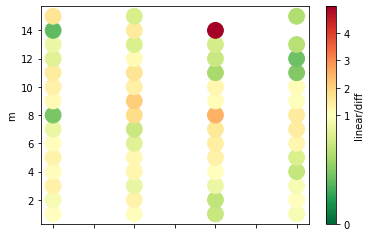

In [6]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0., vcenter=1., vmax=lr_ld["recursive/direct"].max())
lr_ld.reset_index().plot.scatter(x="n", y="m", c="recursive/direct", s=250, cmap="RdYlGn_r", norm=divnorm);

### 5.2. Linear Recursive vs Differential Recursive

In [ ]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0., vcenter=1., vmax=lr_dr["linear/diff"].max())
lr_dr.reset_index().plot.scatter(x="n", y="m", c="linear/diff", s=250, cmap="RdYlGn_r", norm=divnorm);

### 5.3. Linear Direct vs Differential Direct

In [ ]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0., vcenter=1., vmax=ld_dd["linear/diff"].max())
ld_dd.reset_index().plot.scatter(x="n", y="m", c="linear/diff", s=250, cmap="RdYlGn_r", norm=divnorm);

### 5.4. Differential Recursive vs Differential Direct

In [ ]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0., vcenter=1., vmax=dr_dd["recursive/direct"].max())
dr_dd.reset_index().plot.scatter(x="n", y="m", c="recursive/direct", s=250, cmap="RdYlGn_r", norm=divnorm);

### 5.5. Linear Recursive vs Differential Direct

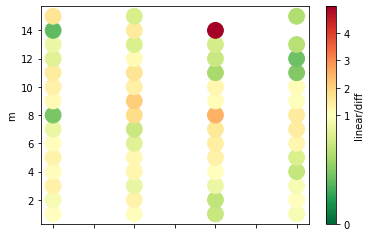

In [6]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0., vcenter=1., vmax=lr_dd["lin_recursive/diff_direct"].max())
lr_dd.reset_index().plot.scatter(x="n", y="m", c="lin_recursive/diff_direct", s=250, cmap="RdYlGn_r", norm=divnorm);

# **Appendix**

## A.1 Example Grünbaum (detailed)

In the article by [Grünbaum](https://doi.org/10.1016/0167-2789(88)90007-3), he tried to compute a commutator of order 6 for an operator of order 4. More precisely, he considered the operator:
$$L_4 = (\partial^2 + c_2/2)^2 + 2c_1\partial + (c_1' + c_0).$$

Then we start by computing a quasi-commuting operator $P_6$ using the differential approach. Then we apply the obtained coefficients and we obtain the equations in the $c_0,c_1$ and $c_2$ to have a commuting operator of order $6$.

In [7]:
B.<K_0,K_3> = QQ[]
R = DifferentialPolynomialRing(DifferentialRing(B, lambda p : 0), names=["c0","c1","c2","z"])
RY.<Y0,Y1,Y2,Y3,Y4,c0,c1,c2,z> = DifferentialPolynomialRing(QQ)

A = z[2] + c2[0]*(1/2)*z[0];
L4 = A(z=A) + 2*c1[0]*z[1] + (c1[1] + c0[0])*z[0]
P6 = P6 = Y0[0]*z[0] + Y1[0]*z[1] + Y2[0]*z[2] + Y3[0]*z[3] + Y4[0]*z[4] + z[6]
C = L4(z=P6) - P6(z=L4)
sols = DSystem([C.coefficient(z[i]) for i in range(3, C.order(z)+1)], variables=[Y0,Y1,Y2,Y3,Y4]).solve_linear()
C_red = C(dic=sols)
c = [R.gen(f'c{i}') for i in range(3)]
E = [R(C_red.coefficient(z[i])) for i in range(3)]
system = DSystem(E, variables=c); system

System over [Ring of operator polynomials in (c0, c1, c2, z) over Differential Ring [[Multivariate Polynomial Ring in K_0, K_3 over Rational Field], (0,)]] with variables [(c0_*, c1_*, c2_*)]:
{
	3/2*c0_0*c1_0*c2_1 + 3*c1_2*c1_0*c2_0 + (-1/2)*c1_2*c2_1*c2_0 + 3*c1_1^2*c2_0 + 6*c1_1*c1_0^2 + 6*c1_1*c1_0*c2_1 + (-3/4)*c1_1*c2_1^2 + 3/2*c1_0^2*c2_2 + (-1/4)*c1_0*c2_2*c2_1 + 1/2*c0_4*c2_0 + (-1/2)*c0_3*c1_0 + 5/4*c0_3*c2_1 + (-3/2)*c0_2*c0_0 + (-9/2)*c0_2*c1_1 + c0_2*c2_2 + (-3/2)*c0_1^2 + (-11/2)*c0_1*c1_2 + 1/4*c0_1*c2_3 + (-3/2)*c0_0*c1_3 + 1/2*c1_5*c2_0 + 5/2*c1_4*c1_0 + 2*c1_4*c2_1 + 15/2*c1_3*c1_1 + 4*c1_3*c2_2 + 5*c1_2^2 + 7/2*c1_2*c2_3 + 3/2*c1_1*c2_4 + 1/4*c1_0*c2_5 + 1/4*c0_6 + 1/4*c1_7 == 0
	6*c1_1*c1_0*c2_0 + 3*c1_0^2*c2_1 + c0_3*c2_0 + (-6)*c0_2*c1_0 + 3/2*c0_2*c2_1 + (-3)*c0_1*c0_0 + (-12)*c0_1*c1_1 + 1/2*c0_1*c2_2 + (-6)*c0_0*c1_2 + 2*c1_4*c2_0 + 5*c1_3*c1_0 + 7*c1_3*c2_1 + 10*c1_2*c1_1 + 9*c1_2*c2_2 + 5*c1_1*c2_3 + c1_0*c2_4 + 1/2*c0_5 + c1_6 == 0
	(-6)*c0_1*c1_0 + (-6)*c0_0*c1_1 + 2*c1_3*c2_0 + 5*c1_2*c2_1 + 4*c1_1*c2_2 + c1_0*c2_3 + c1_5 == 0
}

Now we can start analyzing this system to see that the equations I, II and III of the page 426 of the article are equivalent to the previous system. We recall here the equations I, II, and III from such paper to help in the reading:

$$\left\{\begin{array}{cl}
    (I) & (c_1c_2')' + 2(c_1'c_2)' - 6c_0c_1 + c_1'''' + 6K_0 = 0,\\
    (II) & \frac{1}{2}c_2'c_0' + c_2(c_0'' + 3c_1^2) + \frac{1}{2}c_0'''' - \frac{3}{2}c_0^2 + 5c_1c_1'' + \frac{5}{2}(c_1')^2 - K_3 = 0\\
    (III) & c_0'c_1'' - c_1c_0''' - 6c_1^2c_1' - \frac{3}{2}c_2'K_0 = 0.
\end{array}\right.$$

In [8]:
I = (c[1][0]*c[2][1]).derivative() + 2*(c[1][1]*c[2][0]).derivative() - 6*c[0][0]*c[1][0] + c[1][4] + 6*K_0
II = (1/2)*c[2][1]*c[0][1] + c[2][0]*(c[0][2] + 3*c[1][0]^2) + (1/2)*c[0][4] - (3/2)*c[0][0]^2 + 5*c[1][0]*c[1][2] + (5/2)*c[1][1]^2 - K_3
III = c[0][1]*c[1][2] - c[1][0]*c[0][3] - 6*c[1][0]^2*c[1][1] - (3/2)*c[2][1]*K_0

We can relate (I) with the last equation of our system:

In [9]:
I.derivative() - E[2] == 0

True

The equation (II) comes out from a combination between the second and third equation:

In [10]:
II.derivative() - E[1] + E[2].derivative() == 0

True

Finally, the equation (III) comes out from a combination of all the equations:

In [11]:
III.derivative() + (3/2)*K_0*c[2][2]

(-6)*c1_2*c1_0^2 + (-12)*c1_1^2*c1_0 - c0_4*c1_0 - c0_3*c1_1 + c0_2*c1_2 + c0_1*c1_3

In [12]:
-E[0].derivative() - (1/4)*E[2].derivative(times=3) + (1/2)*E[1].derivative(times=2) -(1/4)*c[2][2]*E[2].inverse_operation(0) -(1/4)*c[2][1]*E[2]

(-6)*c1_2*c1_0^2 + (-12)*c1_1^2*c1_0 - c0_4*c1_0 - c0_3*c1_1 + c0_2*c1_2 + c0_1*c1_3

In [13]:
I == E[2].inverse_operation(0) + 6*K_0

True

## A.2 Counting homogeneous monomials

In section 3 we have provided a bound in the $n$-bonacci numbers. However, that bound looked a bit too big since many of the monomials appearing by derivation also appear in the multiplication part of the recursive construction.

In this section we will check the number of homogeneous monomials for several orders of $L$. 

* Is there any recursive formula for these numbers?
* For a given $m$, we will set up a linear system with as many variables as homogeneous monomials from weights $2,\ldots,m-2$. Is there a formula for this sequence in $n$ and $m$?

### Getting number of homogeneous monomials

In [14]:
__cache_rings = {} # n -> the ring with u0,...u{n-2} and the weight function
def number_homogeneous_monomials(n,d):
    r'''Number of homogeneous monomials for `L` of order `n` and weight `d`'''
    if n not in __cache_rings:
        names_u = ["u"] if n == 2 else [f"u{i}" for i in range(n-1)]
        R = DifferentialPolynomialRing(QQ, *names_u); u = R.gens()
        w = R.weight_func([2+i for i in range(n-1)], [1])
        __cache_rings[n] = (R,u,w)
    R,u,w = __cache_rings[n]
    
    return len(w.homogeneous_monomials(d))

In [15]:
%time Matrix([[number_homogeneous_monomials(n,d) for d in range(15)] for n in range(2,15)])

CPU times: user 24.6 s, sys: 50 ms, total: 24.7 s
Wall time: 24.7 s


[  1   0   1   1   2   2   4   4   7   8  12  14  21  24  34]
[  1   0   1   2   3   4   8  10  17  24  36  50  76 102 148]
[  1   0   1   2   4   5  10  14  25  36  58  84 133 189 286]
[  1   0   1   2   4   6  11  16  29  44  72 108 173 256 395]
[  1   0   1   2   4   6  12  17  31  48  80 122 199 298 468]
[  1   0   1   2   4   6  12  18  32  50  84 130 213 324 512]
[  1   0   1   2   4   6  12  18  33  51  86 134 221 338 538]
[  1   0   1   2   4   6  12  18  33  52  87 136 225 346 552]
[  1   0   1   2   4   6  12  18  33  52  88 137 227 350 560]
[  1   0   1   2   4   6  12  18  33  52  88 138 228 352 564]
[  1   0   1   2   4   6  12  18  33  52  88 138 229 353 566]
[  1   0   1   2   4   6  12  18  33  52  88 138 229 354 567]
[  1   0   1   2   4   6  12  18  33  52  88 138 229 354 568]

Curious enough, the number of homogeneous monomials stabilizes when increasing $n$ and, as a sequence, it converge to the sequence [A052847](https://oeis.org/A052847). 

### Getting number of variables in linear system

In [16]:
def number_of_variables_to_solve(n,m):
    return sum(number_homogeneous_monomials(n,d) for d in range(2, m-1))

In [17]:
%time Matrix([[number_of_variables_to_solve(n,m) for m in range(15)] for n in range(2,15)])

CPU times: user 910 µs, sys: 2 µs, total: 912 µs
Wall time: 913 µs


[  0   0   0   0   1   2   4   6  10  14  21  29  41  55  76]
[  0   0   0   0   1   3   6  10  18  28  45  69 105 155 231]
[  0   0   0   0   1   3   7  12  22  36  61  97 155 239 372]
[  0   0   0   0   1   3   7  13  24  40  69 113 185 293 466]
[  0   0   0   0   1   3   7  13  25  42  73 121 201 323 522]
[  0   0   0   0   1   3   7  13  25  43  75 125 209 339 552]
[  0   0   0   0   1   3   7  13  25  43  76 127 213 347 568]
[  0   0   0   0   1   3   7  13  25  43  76 128 215 351 576]
[  0   0   0   0   1   3   7  13  25  43  76 128 216 353 580]
[  0   0   0   0   1   3   7  13  25  43  76 128 216 354 582]
[  0   0   0   0   1   3   7  13  25  43  76 128 216 354 583]
[  0   0   0   0   1   3   7  13  25  43  76 128 216 354 583]
[  0   0   0   0   1   3   7  13  25  43  76 128 216 354 583]

## A.3 Recursion on the linear approach

The differential approach has a key advantage with respect to the linear approach.
* The differential approach, if we keep the constants throughout the computation, produces all elements in the quasi-commuting basis with just one computation.
* The linear approach only serves for one specific element in the basis. 

However, we can try and reuse part of the computations to, from the linear system for a fixed value of $m$, produce the system for $m+1$.

In the general approach, we start with a fixed $m$ and generate the following differential operator:
$$P_m = \partial^m + p_{m-2} \partial^{m-2} + \ldots p_{0},$$
where the element $p_j$ has weight $m-j$ or, equivalently, the element $p_{m-j}$ has weight $j$. For shake of simplicity, let $p_j$ be the homogeneous ansatz element of weight $j$ for a fixed ring of differential polynomials $R\{u_0,\ldots,u_{n-2}\}$, where $u_{n-i}^{(k)}$ has weight $i+k$. Then we can write:
$$P_{m} = P_{m-1}\partial + p_m,$$
so when we look into the commutator with $L_n$ we obtain:
$$\begin{array}{rl}
    [L_n, P_m] = & [L_n, P_{m-1}\partial + p_m] = [L_n, P_{m-1}\partial] + [L_n, p_m]\\
               = & L_nP_{m-1}\partial - P_{m-1}\partial L_n + L_np_m - p_mL_n.
\end{array}$$

Using the fact that $\partial u_i = u_i' + u_i\partial$, we have that $\partial L_n = L_n\partial + \kappa_\partial(L_n)$, where the $\kappa_\partial$ is the operator computed from $L_n$ by computing the derivative of each of its coefficients. Hence, we can then write the commutator of $L_n$ with $P_{m}$ using the commutator of $L_n$ with $P_{m-1}$:
$$\begin{array}{rl}
    [L_n, P_m] = & L_nP_{m-1}\partial - P_{m-1}\partial L_n + L_np_m - p_mL_n \\
               = & [L_n, P_{m-1}]\partial - \kappa_\partial(L_n) + [L_n, p_m]
\end{array}$$

Let us analyze how we can extract the coefficient of $\partial^{n+m-j}$ for $j=1,\ldots,m+1$ (which are the equations we are interested in) from the different parts of the previous formula.

**The recursive part $[L_n, P_{m-1}]\partial$**

This seems to be the easiest since the coefficient of $\partial^i$ of $[L_n, P_{m-1}]\partial$ is equal to **the coefficient of $\partial^{i-1}$ of $[L_n, P_{m-1}]$** with the exception of $i = 0$, where we obtain a coefficient of $0$.

**The direct derivative part $\kappa_\partial(L_n)$**

Here we have that
$$\kappa_\partial(L_n) = \sum_{i=0}^{n-2} u_{i}'\partial.$$
Since we are only interested in the coefficients of $\partial^{n+m-j}$ for $j = 1,\ldots, m+1$, we would get coefficients of orders $n-1, n, n+1,\ldots, n+m-1$. Hence this term of the commutator **do not contribute to the system for the quasi-commutation**. It would contribute to the equations of the integrable hierarchies, but that would be a different problem.

**The commutator with a differential element $[L_n, p_m]$**

This is an interesting element that we can expand a bit further:
$$\begin{array}{rl}
    [L_n, p_m] = & L_np_m - p_mL_n = \left(\partial^n + \sum_{i=0}^{n-2}u_i\partial^i\right)p_m - p_mL_n\\
               = & \left(\left(\sum_{j=0}^n \binom{n}{j}p_m^{(n-j)}\partial^j\right) + \left(\sum_{i=0}^{n-2} \sum_{j=0}^i \binom{i}{j}u_ip_m^{(i-j)}\right)\right) + p_mL_n
               = & I + II + III
\end{array}$$

1. The first summand if a very simple term of order $n$, and will contribute $p_m^{(n)}$ for the order $n$ and $np_m^{(n-1)}$ for the order $n-1$. The other higher order coefficients do no have any contribution from this term.
2. The second summand has order $n-2$, hence it will nto contribute to any of the coefficients we are interested in.
3. The third summand has order $n$ and contributes $p_m$ for the order $n$ and $0$ for the order $n-1$.

**Collecting all parts for the new system**

* Coefficients of order $n+m-j$ with $j=1,\ldots,m-1$: only the first term contribute with the coefficient of order $n+(m-1)-j$ of the commutator of $[L,P_{m-1}]$. Hence the equation is the same.
* Coefficient of order $n = n+m-m$ ($j=m$): first, we have the term $n-1$ of $[L,P_{m-1}]$ which is the last equation from the previous system. Second, we obtain a $p_m^{(n)}$ from $I$ and finally, we get the element $p_m$ from $III$. 
* Coefficient of order $n-1 = n+m-(m+1)$ ($j=m+1$): this will involve the coefficient $n-2$ of $[L,P_{m-1}]$, which did not show up in the previous system, hence we need to keep track of this coefficient too for every step. Secondly, we get an $np_m^{(n-1)}$ from $I$ and $0$ from $III$.

**Conclusions**

It seems that the first part of all systems will be the same, hence its solution will be equal. This mean that we will be able to reuse part of the computations of $P_{m-1}$ with the computation of $P_m$. How exactly it is nto clear. These computations seems quite strong and does not fit what we got so far in the examples:

In [19]:
n = 3; m = 7
names_u = [f"u{i}" for i in range(n-1)] if n > 2 else ["u"]; 
names_p = [f"p{j+2}" for j in range(m-1)] if n > 2 else ["p2"]; 
R = DifferentialPolynomialRing(QQ, names_u+names_p+["z"])
u = [R.gen(f"u{i}") for i in range(n-1)]; p = 2*[None] + [R.gen(f"p{j+2}") for j in range(m-1)]; z = R.gen("z")

Ln = z[n] + sum(u[i][0]*z[i] for i in range(n-1))
P = (n)*[None] +[z[n] + sum(p[n-i][0]*z[i] for i in range(n-1))]
while(len(P) <= m):
    cm = len(P)
    P.append(P[-1](z=z[1]) + p[cm][0])
    
C = (n)*[None] + [(Ln(z=P[i]) - P[i](z=Ln)) for i in range(n,m+1)]

In [20]:
S = {j: DSystem([C[j].coefficient(z[i]) for i in range(n-1,C[j].order(z)+1)], variables=p) for j in range(n,m+1)}

In [21]:
S[3]

System over [Ring of operator polynomials in (p2, p3, p4, p5, p6, p7, u0, u1, z) over Differential Ring [[Rational Field], (0,)]] with variables [(p2_*, p3_*, p4_*, p5_*, p6_*, p7_*)]:
{
	3*p2_2 + 3*p3_1 + (-3)*u0_1 + (-3)*u1_2 == 0
	3*p2_1 + (-3)*u1_1 == 0
}

In [22]:
S[4]

System over [Ring of operator polynomials in (p2, p3, p4, p5, p6, p7, u0, u1, z) over Differential Ring [[Rational Field], (0,)]] with variables [(p2_*, p3_*, p4_*, p5_*, p6_*, p7_*)]:
{
	p2_1*u1_0 + (-2)*p2_0*u1_1 + p2_3 + 3*p3_2 + (-6)*u0_2 + (-4)*u1_3 == 0
	3*p2_2 + 3*p3_1 + (-4)*u0_1 + (-6)*u1_2 == 0
	3*p2_1 + (-4)*u1_1 == 0
}

In [23]:
S[5]

System over [Ring of operator polynomials in (p2, p3, p4, p5, p6, p7, u0, u1, z) over Differential Ring [[Rational Field], (0,)]] with variables [(p2_*, p3_*, p4_*, p5_*, p6_*, p7_*)]:
{
	(-3)*p2_0*u0_1 + (-3)*p2_0*u1_2 + p3_1*u1_0 + (-2)*p3_0*u1_1 + p3_3 + (-10)*u0_3 + (-5)*u1_4 == 0
	p2_1*u1_0 + (-3)*p2_0*u1_1 + p2_3 + 3*p3_2 + (-10)*u0_2 + (-10)*u1_3 == 0
	3*p2_2 + 3*p3_1 + (-5)*u0_1 + (-10)*u1_2 == 0
	3*p2_1 + (-5)*u1_1 == 0
}

In [24]:
S[6]

System over [Ring of operator polynomials in (p2, p3, p4, p5, p6, p7, u0, u1, z) over Differential Ring [[Rational Field], (0,)]] with variables [(p2_*, p3_*, p4_*, p5_*, p6_*, p7_*)]:
{
	(-6)*p2_0*u0_2 + (-4)*p2_0*u1_3 + (-3)*p3_0*u0_1 + (-3)*p3_0*u1_2 + (-15)*u0_4 + (-6)*u1_5 == 0
	(-4)*p2_0*u0_1 + (-6)*p2_0*u1_2 + p3_1*u1_0 + (-3)*p3_0*u1_1 + p3_3 + (-20)*u0_3 + (-15)*u1_4 == 0
	p2_1*u1_0 + (-4)*p2_0*u1_1 + p2_3 + 3*p3_2 + (-15)*u0_2 + (-20)*u1_3 == 0
	3*p2_2 + 3*p3_1 + (-6)*u0_1 + (-15)*u1_2 == 0
	3*p2_1 + (-6)*u1_1 == 0
}

In [25]:
S[7]

System over [Ring of operator polynomials in (p2, p3, p4, p5, p6, p7, u0, u1, z) over Differential Ring [[Rational Field], (0,)]] with variables [(p2_*, p3_*, p4_*, p5_*, p6_*, p7_*)]:
{
	(-10)*p2_0*u0_3 + (-5)*p2_0*u1_4 + (-6)*p3_0*u0_2 + (-4)*p3_0*u1_3 + (-21)*u0_5 + (-7)*u1_6 == 0
	(-10)*p2_0*u0_2 + (-10)*p2_0*u1_3 + (-4)*p3_0*u0_1 + (-6)*p3_0*u1_2 + (-35)*u0_4 + (-21)*u1_5 == 0
	(-5)*p2_0*u0_1 + (-10)*p2_0*u1_2 + p3_1*u1_0 + (-4)*p3_0*u1_1 + p3_3 + (-35)*u0_3 + (-35)*u1_4 == 0
	p2_1*u1_0 + (-5)*p2_0*u1_1 + p2_3 + 3*p3_2 + (-21)*u0_2 + (-35)*u1_3 == 0
	3*p2_2 + 3*p3_1 + (-7)*u0_1 + (-21)*u1_2 == 0
	3*p2_1 + (-7)*u1_1 == 0
}

**Conclusions 2**

It seems that the "structure" of the system is the same extended by 1 equation but the coefficients change slightly. Where was the mistake in the previous formulas?